In [1]:
import os
import pickle
import numpy as np
from multiprocessing import cpu_count
from multiprocessing.pool import ThreadPool
import pandas as pd
from dataset_preparator import DataSetPreparator
from multinomial_expectation_maximizer import (
    MultinomialExpectationMaximizer,
    IndividualMultinomialExpectationMaximizer,
)
import re
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import multinomial

%matplotlib inline

In [2]:
def get_individual_alpha_test(best_alpha, test_household_ids, train_household_ids):
    alpha_df = pd.DataFrame(best_alpha, index=train_household_ids)
    filtered_alpha_df = alpha_df.groupby(alpha_df.index).apply(lambda g: g.iloc[0])
    alpha_test = np.vstack([filtered_alpha_df.loc[household_id].values for household_id in test_household_ids])
    return alpha_test


def process_with_k_mixtures(args):
    k, X_train, X_test, train_household_ids, test_household_ids, individual_mode, save = args
    print('###################################### Experiment with %i mixture components ######################################' % k)
    
    if individual_mode:
        best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma = pickle.load(open('run_with_gamma/best_params_%i.p' % k, 'rb'))
        model = IndividualMultinomialExpectationMaximizer(k, best_alpha, best_beta, train_household_ids,
                                                          restarts=10, rtol=1e-4)
        best_train_loss, best_alpha, best_beta, best_gamma = model.fit(X_train)
        alpha_test = get_individual_alpha_test(best_alpha, test_household_ids, train_household_ids)
    else:
        model = MultinomialExpectationMaximizer(k, restarts=10, rtol=1e-4)
        best_train_loss, best_alpha, best_beta, best_gamma = model.fit(X_train)
        alpha_test = best_alpha

    log_likelihood = model.compute_log_likelihood(X_test, alpha_test, best_beta)
    bic = model.compute_bic(X_test, best_alpha, best_beta, log_likelihood)
    icl_bic = model.compute_icl_bic(bic, best_gamma)

    print('log likelihood for k=%i : %f' % (k, log_likelihood))
    print('bic for k=%i : %f' % (k, bic))
    print('icl bic for k=%i : %f' % (k, icl_bic))
    pickle.dump((best_train_loss, log_likelihood, bic, best_alpha, best_beta, best_gamma),
                open(os.path.join(save, 'best_params_%i.p' % k), 'wb'))


In [3]:
def load_data(from_disk, save):
    if from_disk:
        train_grocery_df, test_grocery_df, X_train, X_test, train_household_ids, test_household_ids = \
            pickle.load(open(os.path.join(save, 'data.p'), 'rb'))
        return X_train, X_test, train_household_ids, test_household_ids

    transactions_filepath = 'data/transaction_data.csv'
    products_filepath = 'data/product.csv'

    train_grocery_df, test_grocery_df, train_counts_df, test_counts_df = DataSetPreparator.prepare(
        transactions_filepath, products_filepath)
    train_household_ids = train_counts_df.index.droplevel(level=1)
    test_household_ids = test_counts_df.index.droplevel(level=1)
    X_train, X_test = train_counts_df.values, test_counts_df.values

    unknown_ids = set(test_household_ids).difference(set(train_household_ids))
    X_test = X_test[~test_household_ids.isin(unknown_ids)]
    test_household_ids = test_household_ids[~test_household_ids.isin(unknown_ids)]

    data = (
    train_grocery_df, test_grocery_df, train_counts_df, test_counts_df, train_household_ids, test_household_ids)
    pickle.dump(data, open(os.path.join(save, 'data.p'), 'wb'))

    return X_train, X_test, train_household_ids, test_household_ids

In [4]:
#Global
if __name__ == '__main__':
    X_train, X_test, train_household_ids, test_household_ids = load_data(from_disk=False, save='run_with_gamma')

    individual_mode = False
    ## Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50]
    save = 'run_with_gamma'
    params = [(k, X_train, X_test, train_household_ids, test_household_ids, individual_mode, save) for k in Ks]
    p_counts = cpu_count()
    with ThreadPool(processes=p_counts) as pool:
         pool.map(process_with_k_mixtures, params)


###################################### Experiment with 2 mixture components ############################################################################ Experiment with 3 mixture components ######################################
iteration 0
###################################### Experiment with 4 mixture components ######################################
iteration 0
###################################### Experiment with 5 mixture components ######################################
iteration 0

iteration 0
###################################### Experiment with 6 mixture components ######################################
iteration 0
###################################### Experiment with 7 mixture components ######################################
iteration 0
###################################### Experiment with 8 mixture components ######################################
iteration 0
###################################### Experiment with 9 mixture components ###################################

In [4]:
#Individual
if __name__ == '__main__':
    X_train, X_test, train_household_ids, test_household_ids = load_data(from_disk=False, save='run_with_individual')

    individual_mode = True
    ## Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    Ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 50]
    save = 'run_with_individual'
    params = [(k, X_train, X_test, train_household_ids, test_household_ids, individual_mode, save) for k in Ks]
    p_counts = cpu_count()
    with ThreadPool(processes=p_counts) as pool:
         pool.map(process_with_k_mixtures, params)

###################################### Experiment with 2 mixture components ############################################################################ Experiment with 3 mixture components ######################################
###################################### Experiment with 4 mixture components ######################################

###################################### Experiment with 5 mixture components ######################################
###################################### Experiment with 6 mixture components ######################################
###################################### Experiment with 7 mixture components ######################################
###################################### Experiment with 8 mixture components ######################################
###################################### Experiment with 9 mixture components ######################################
###################################### Experiment with 10 mixture components ###

# __Model Selection__

In [143]:
import re
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multinomial

%matplotlib inline

In [144]:
train_grocery_df, test_grocery_df, X_train, X_test, train_household_ids, test_household_ids = pickle.load(open(r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\data.p", 'rb'))


In [146]:
def multinomial_prob(counts, beta):
    n = counts.sum(axis=-1)
    m = multinomial(n, beta)
    return m.pmf(counts)

def compute_log_likelihood(X_test, alpha, beta):
    mn_probs = np.zeros(X_test.shape[0])
    for k in range(beta.shape[0]):
        mn_probs_k = alpha[k] * multinomial_prob(X_test, beta[k])
        mn_probs += mn_probs_k
    mn_probs[mn_probs == 0] = np.finfo(float).eps
    return np.log(mn_probs).sum()

def compute_bic(X_test, alpha, beta, log_likelihood=None):
    if log_likelihood is None:
        log_likelihood = compute_log_likelihood(X_test, alpha, beta)
    N = X_test.shape[0]
    if len(alpha.shape) == 2:
        unique_alpha = np.unique(alpha, axis=0)
        nb_params_penalty = (unique_alpha.shape[0] * unique_alpha.shape[1] - 1) + (beta.shape[0] * (beta.shape[0] - 1))
    else:
        nb_params_penalty = (alpha.shape[0] - 1) + (beta.shape[0] * (beta.shape[0] - 1))
    return -log_likelihood + (0.5 * np.log(N) * nb_params_penalty)

def get_fit_metrics(pickle_dir, load_pickle):
    bics = {}
    likelihoods = {}
    for filename in tqdm(os.listdir(pickle_dir)):
        match = re.match('best_params_([0-9]+).p', filename)    
        if match is None:
            continue
        filepath = os.path.join(pickle_dir, filename)
        test_log_likelihood, best_alpha, best_beta, best_gamma = load_pickle(filepath)
        k = int(match.groups()[0])
        likelihoods[k] = test_log_likelihood
        bics[k] = compute_bic(X_test, best_alpha, best_beta, test_log_likelihood)
    return likelihoods, bics

def plot_values_by_k(values_by_k, title, label, ax, plot_min=None):
    sorted_kvp = list(sorted(values_by_k.items(), key=lambda kvp: kvp[0]))
    keys = [l[0] for l in sorted_kvp]
    values = [l[1] for l in sorted_kvp]
    sns.scatterplot(x=keys, y=values, ax=ax, label=label)
    ax.set_title(title)
    ax.set_xlabel('Number of clusters')
    if plot_min is not None:
        min_key = plot_min
        min_idx = [i for i, k in enumerate(keys) if k == plot_min][0]
        ax.scatter([min_key], [values[min_idx]], color='red')

def plot_fit_metrics(pickle_dir, load_pickle):
    likelihoods, bics, icl_bics = get_fit_metrics(pickle_dir, load_pickle)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    axes = axes.ravel()
    plot_values_by_k(likelihoods, 'Likelihood', axes[0])
    plot_values_by_k(bics, 'BIC', axes[1], plot_min=True)

def compare_fit_metrics(pickle_dir1, pickle_dir2, load_pickle):
    likelihoods1, bics1 = get_fit_metrics(pickle_dir1, load_pickle)
    likelihoods2, bics2 = get_fit_metrics(pickle_dir2, load_pickle)
    
    bics1.pop(1, None)
    bics2.pop(1, None)
    
    fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
    axes = axes.ravel()
    plot_values_by_k(likelihoods1, 'Likelihood', 'Global', axes[0])
    plot_values_by_k(likelihoods2, 'Likelihood', 'Individual', axes[0])
    axes[0].legend()
    plot_values_by_k(bics1, 'BIC', 'Global', axes[1], plot_min=30)
    plot_values_by_k(bics2, 'BIC', 'Individual', axes[1], plot_min=2)
    axes[1].legend()

def load_pickle(filepath):
    best_train_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = args = pickle.load(open(filepath, 'rb'))
    return test_log_likelihood, best_alpha, best_beta, best_gamma

100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


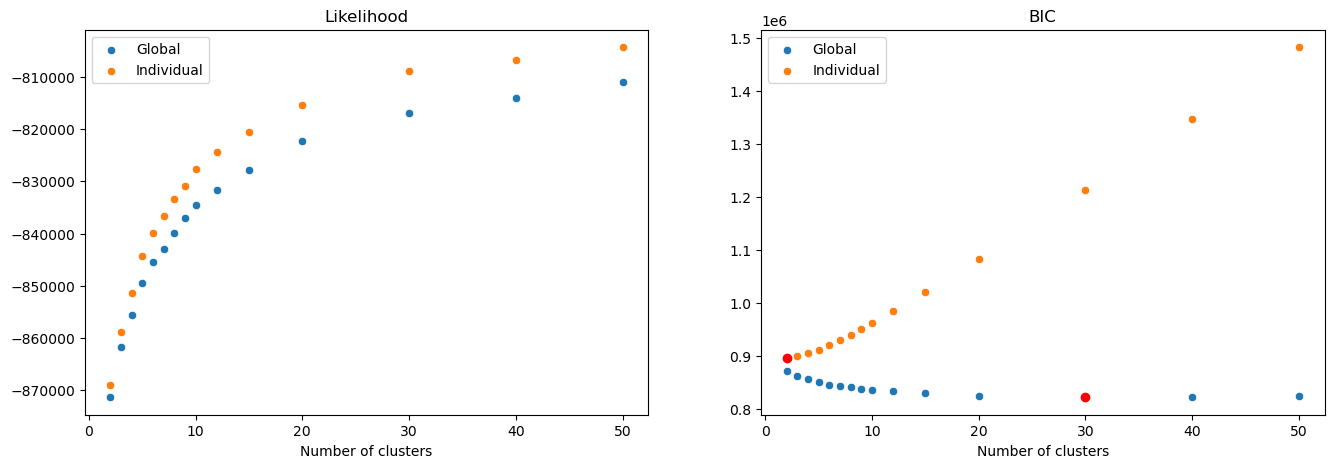

In [147]:
global_results_dir = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma"
individual_results_dir =r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_individual"

compare_fit_metrics(global_results_dir, individual_results_dir, load_pickle)

# __Analyze Results: Global Model__

In [37]:
## file_path = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\data.p"
train_grocery_df, test_grocery_df, train_counts_df, test_counts_df, train_household_ids, test_household_ids = pickle.load(open(r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\data.p", 'rb'))

In [38]:
## file_path = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\best_params_50.p"
## best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open('/home/adrien/Projects/MNMM/run_with_gamma/best_params_30.p', 'rb'))
best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open(r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\best_params_50.p", 'rb'))

In [39]:
test_log_likelihood

-811031.6741903251

In [40]:
test_bic

1672749.1641722817

### Visualize cluster category probabilities

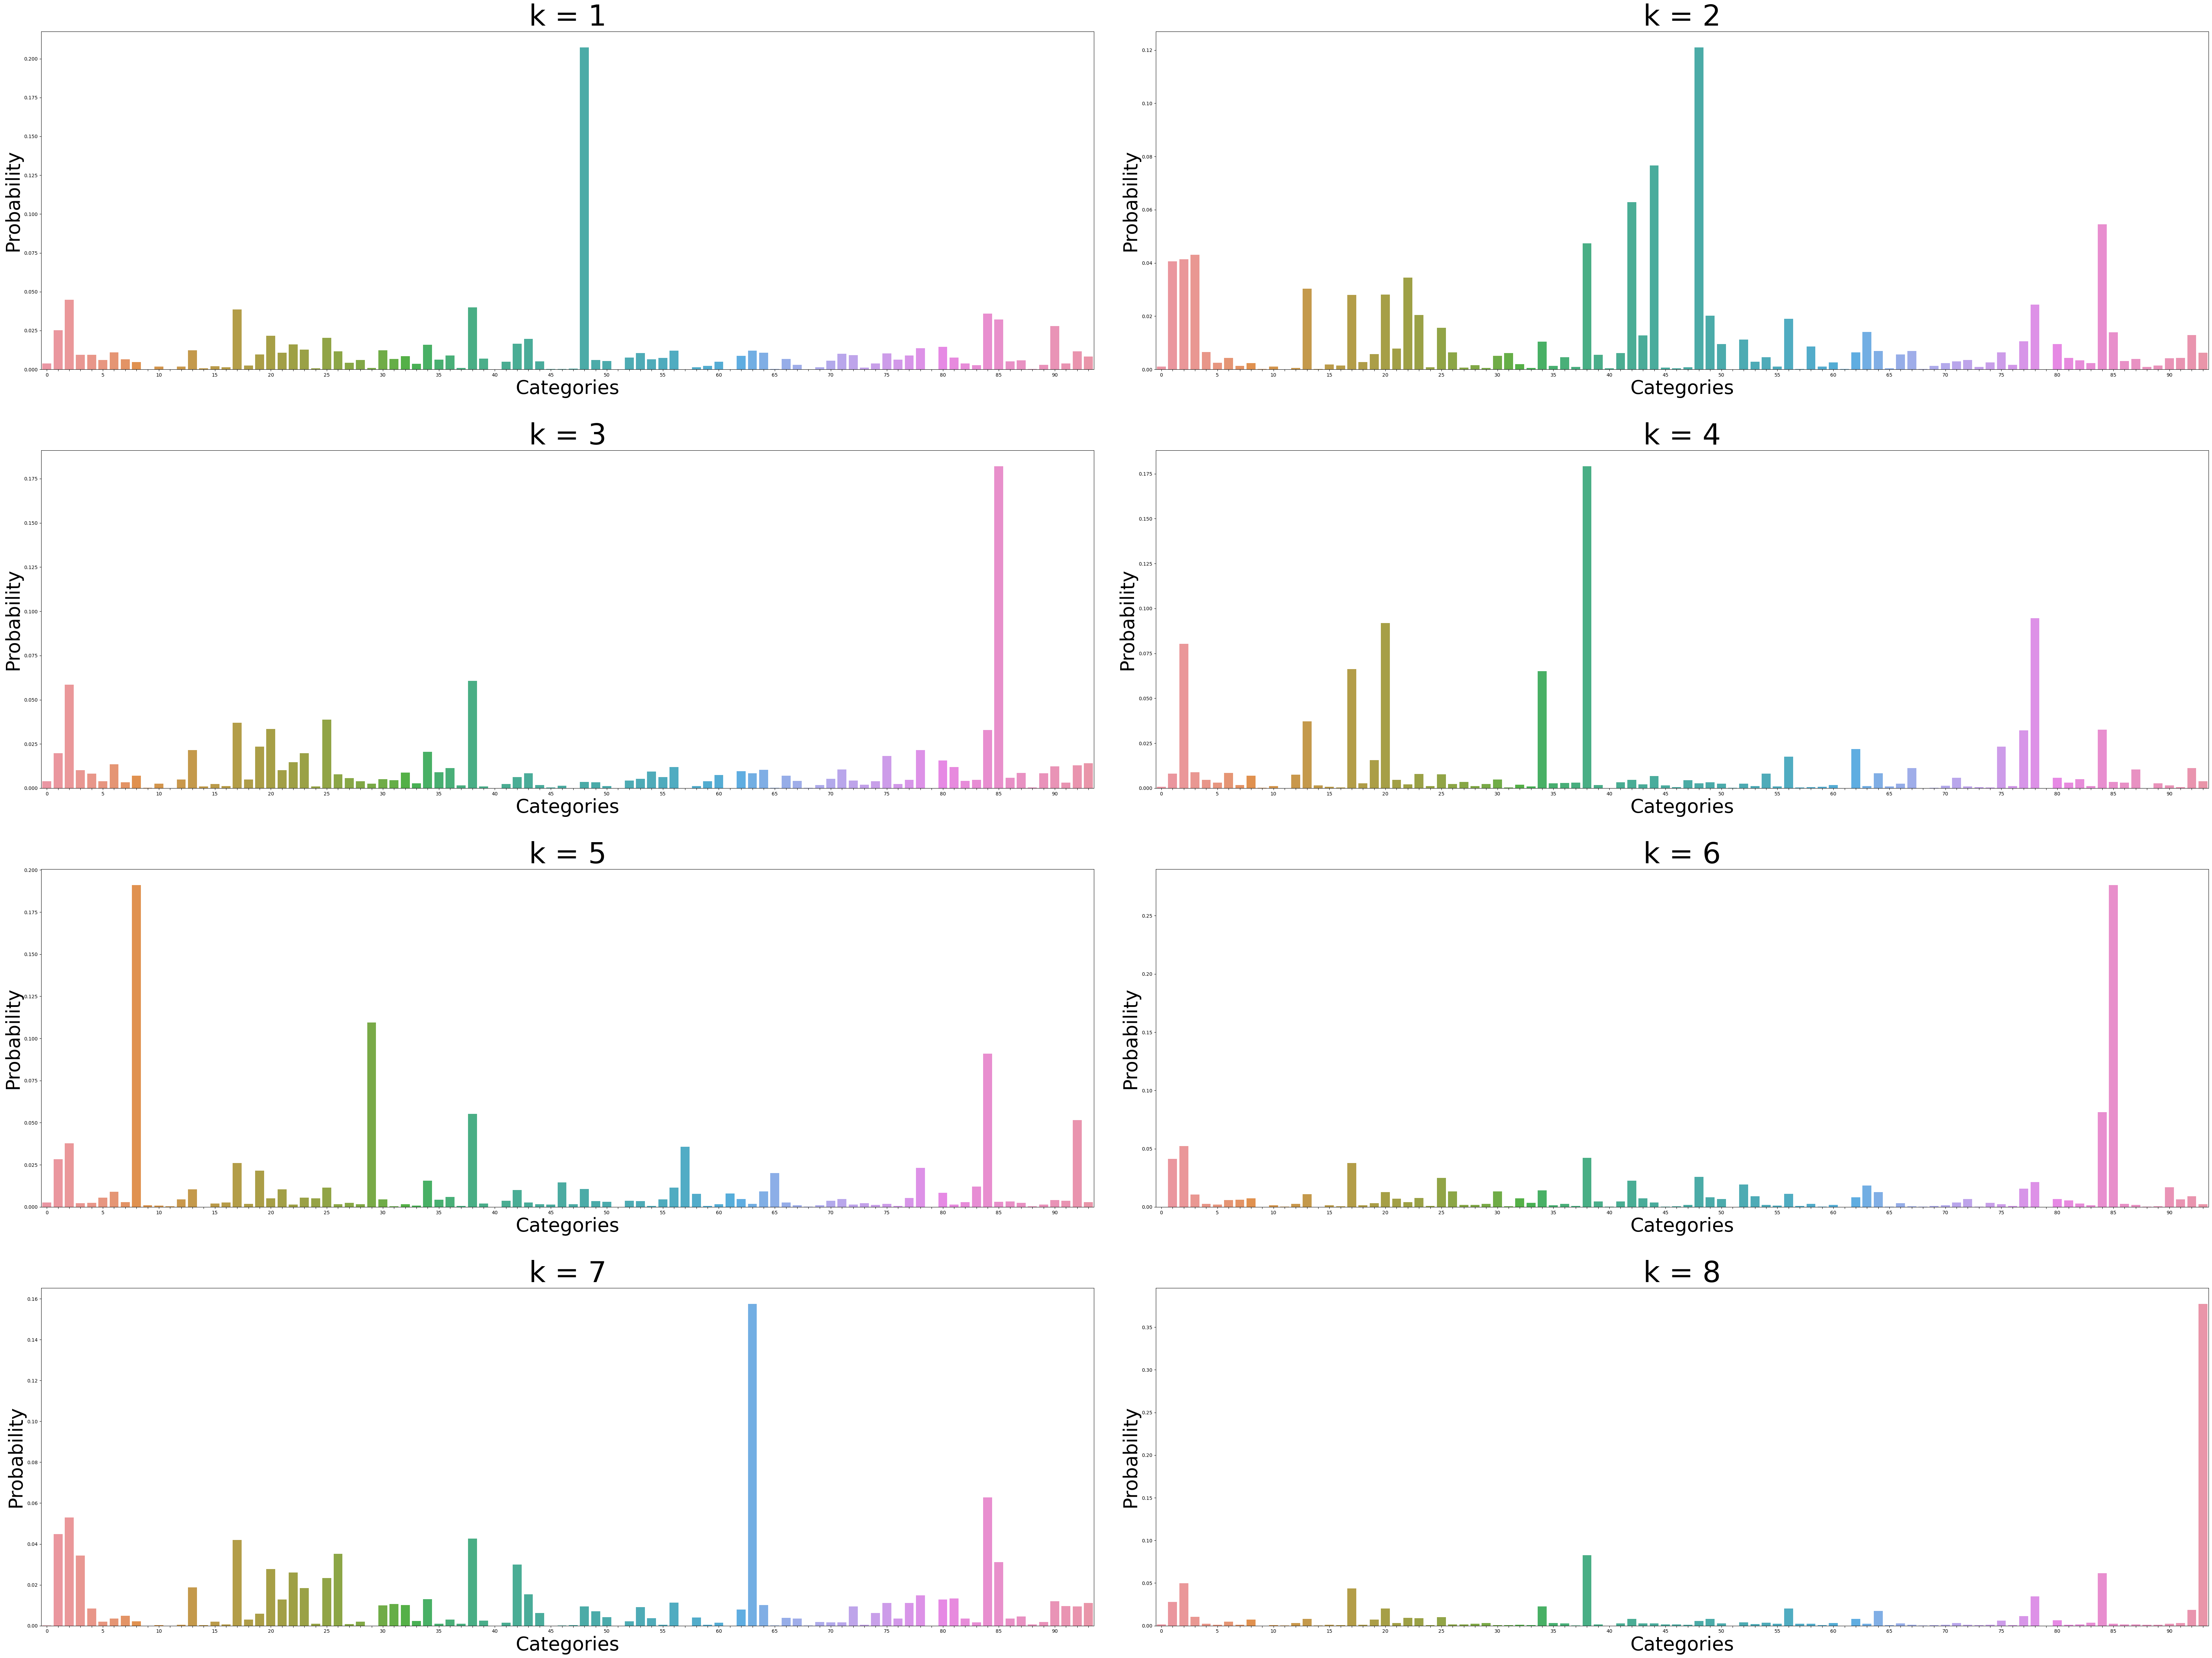

In [41]:
def hide_tick_labels(every_nth, ax):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

K, C = best_beta.shape
K = 8
fig, axes = plt.subplots(nrows=(K // 2), ncols=2, figsize=(64, 48))
k = 0
i = 0
while k < K:
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][0])
    hide_tick_labels(5, axes[i][0])
    axes[i][0].set_title('k = %i' % (k + 1), size=60)
    axes[i][0].set_xlabel('Categories', size=40)
    axes[i][0].set_ylabel('Probability', size=40)
    k += 1

    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[i][1])
    hide_tick_labels(5, axes[i][1])
    axes[i][1].set_title('k = %i' % (k + 1), size=60)
    axes[i][1].set_xlabel('Categories', size=40)
    axes[i][1].set_ylabel('Probability', size=40)

    k += 1
    i += 1

fig.tight_layout(h_pad=5, w_pad=5)

plt.show()


## Visualize cluster distances

In [42]:
from sklearn.metrics.pairwise import manhattan_distances

beta_distances = manhattan_distances(best_beta)

In [43]:
beta_distances.shape

(50, 50)

In [44]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed')
beta_distances_transformed = embedding.fit_transform(beta_distances)

c:\Users\Tinga\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


C:\Users\Tinga\AppData\Local\Temp\ipykernel_27240\4147813601.py:14: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for i, handle in enumerate(lgnd.legendHandles):


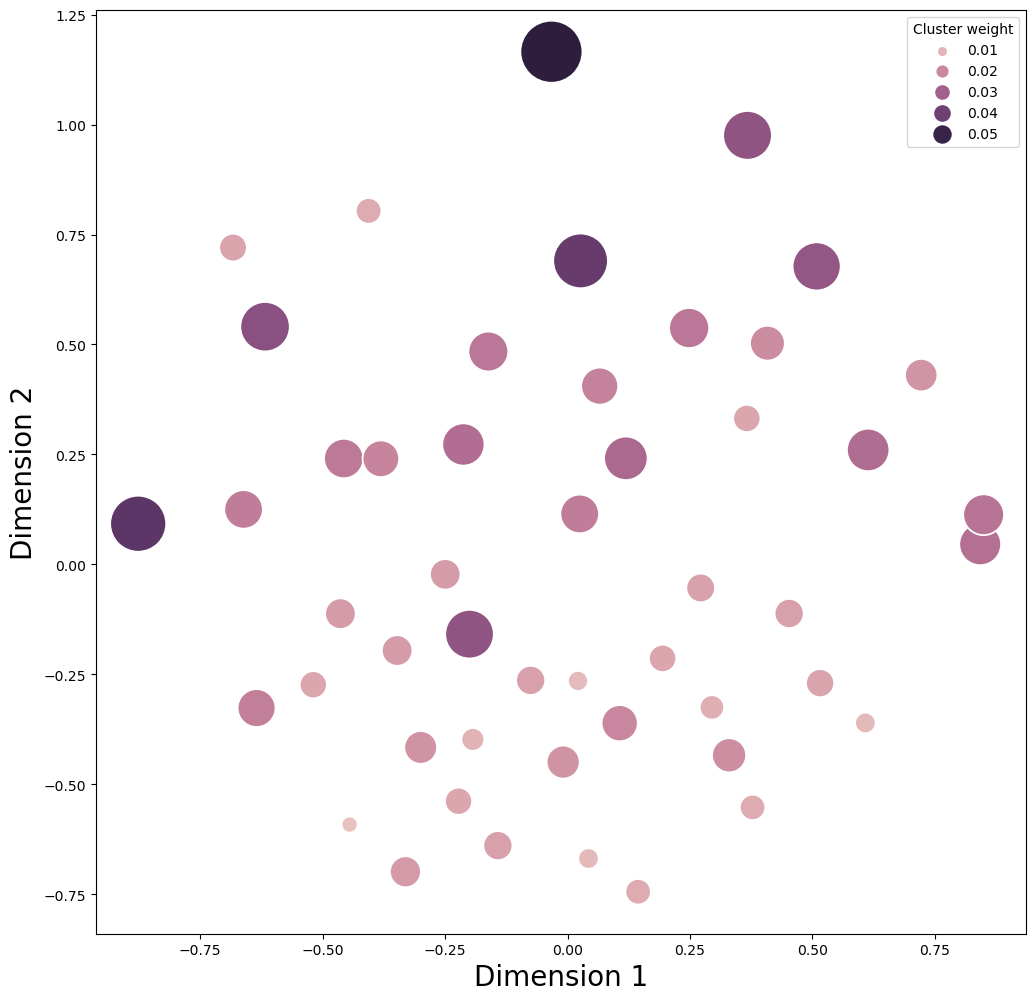

In [45]:
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(
    x=beta_distances_transformed[:, 0],
    y=beta_distances_transformed[:, 1],
    size=best_alpha,
    hue=best_alpha,
    sizes=(1, 2000)
)
ax.set_xlabel('Dimension 1', size=20)
ax.set_ylabel('Dimension 2', size=20)

# Plot legend.
lgnd = ax.legend(title='Cluster weight')
for i, handle in enumerate(lgnd.legendHandles):
    handle._sizes = [(i+1) * 30]

plt.show()


## Describe clusters by high lift items

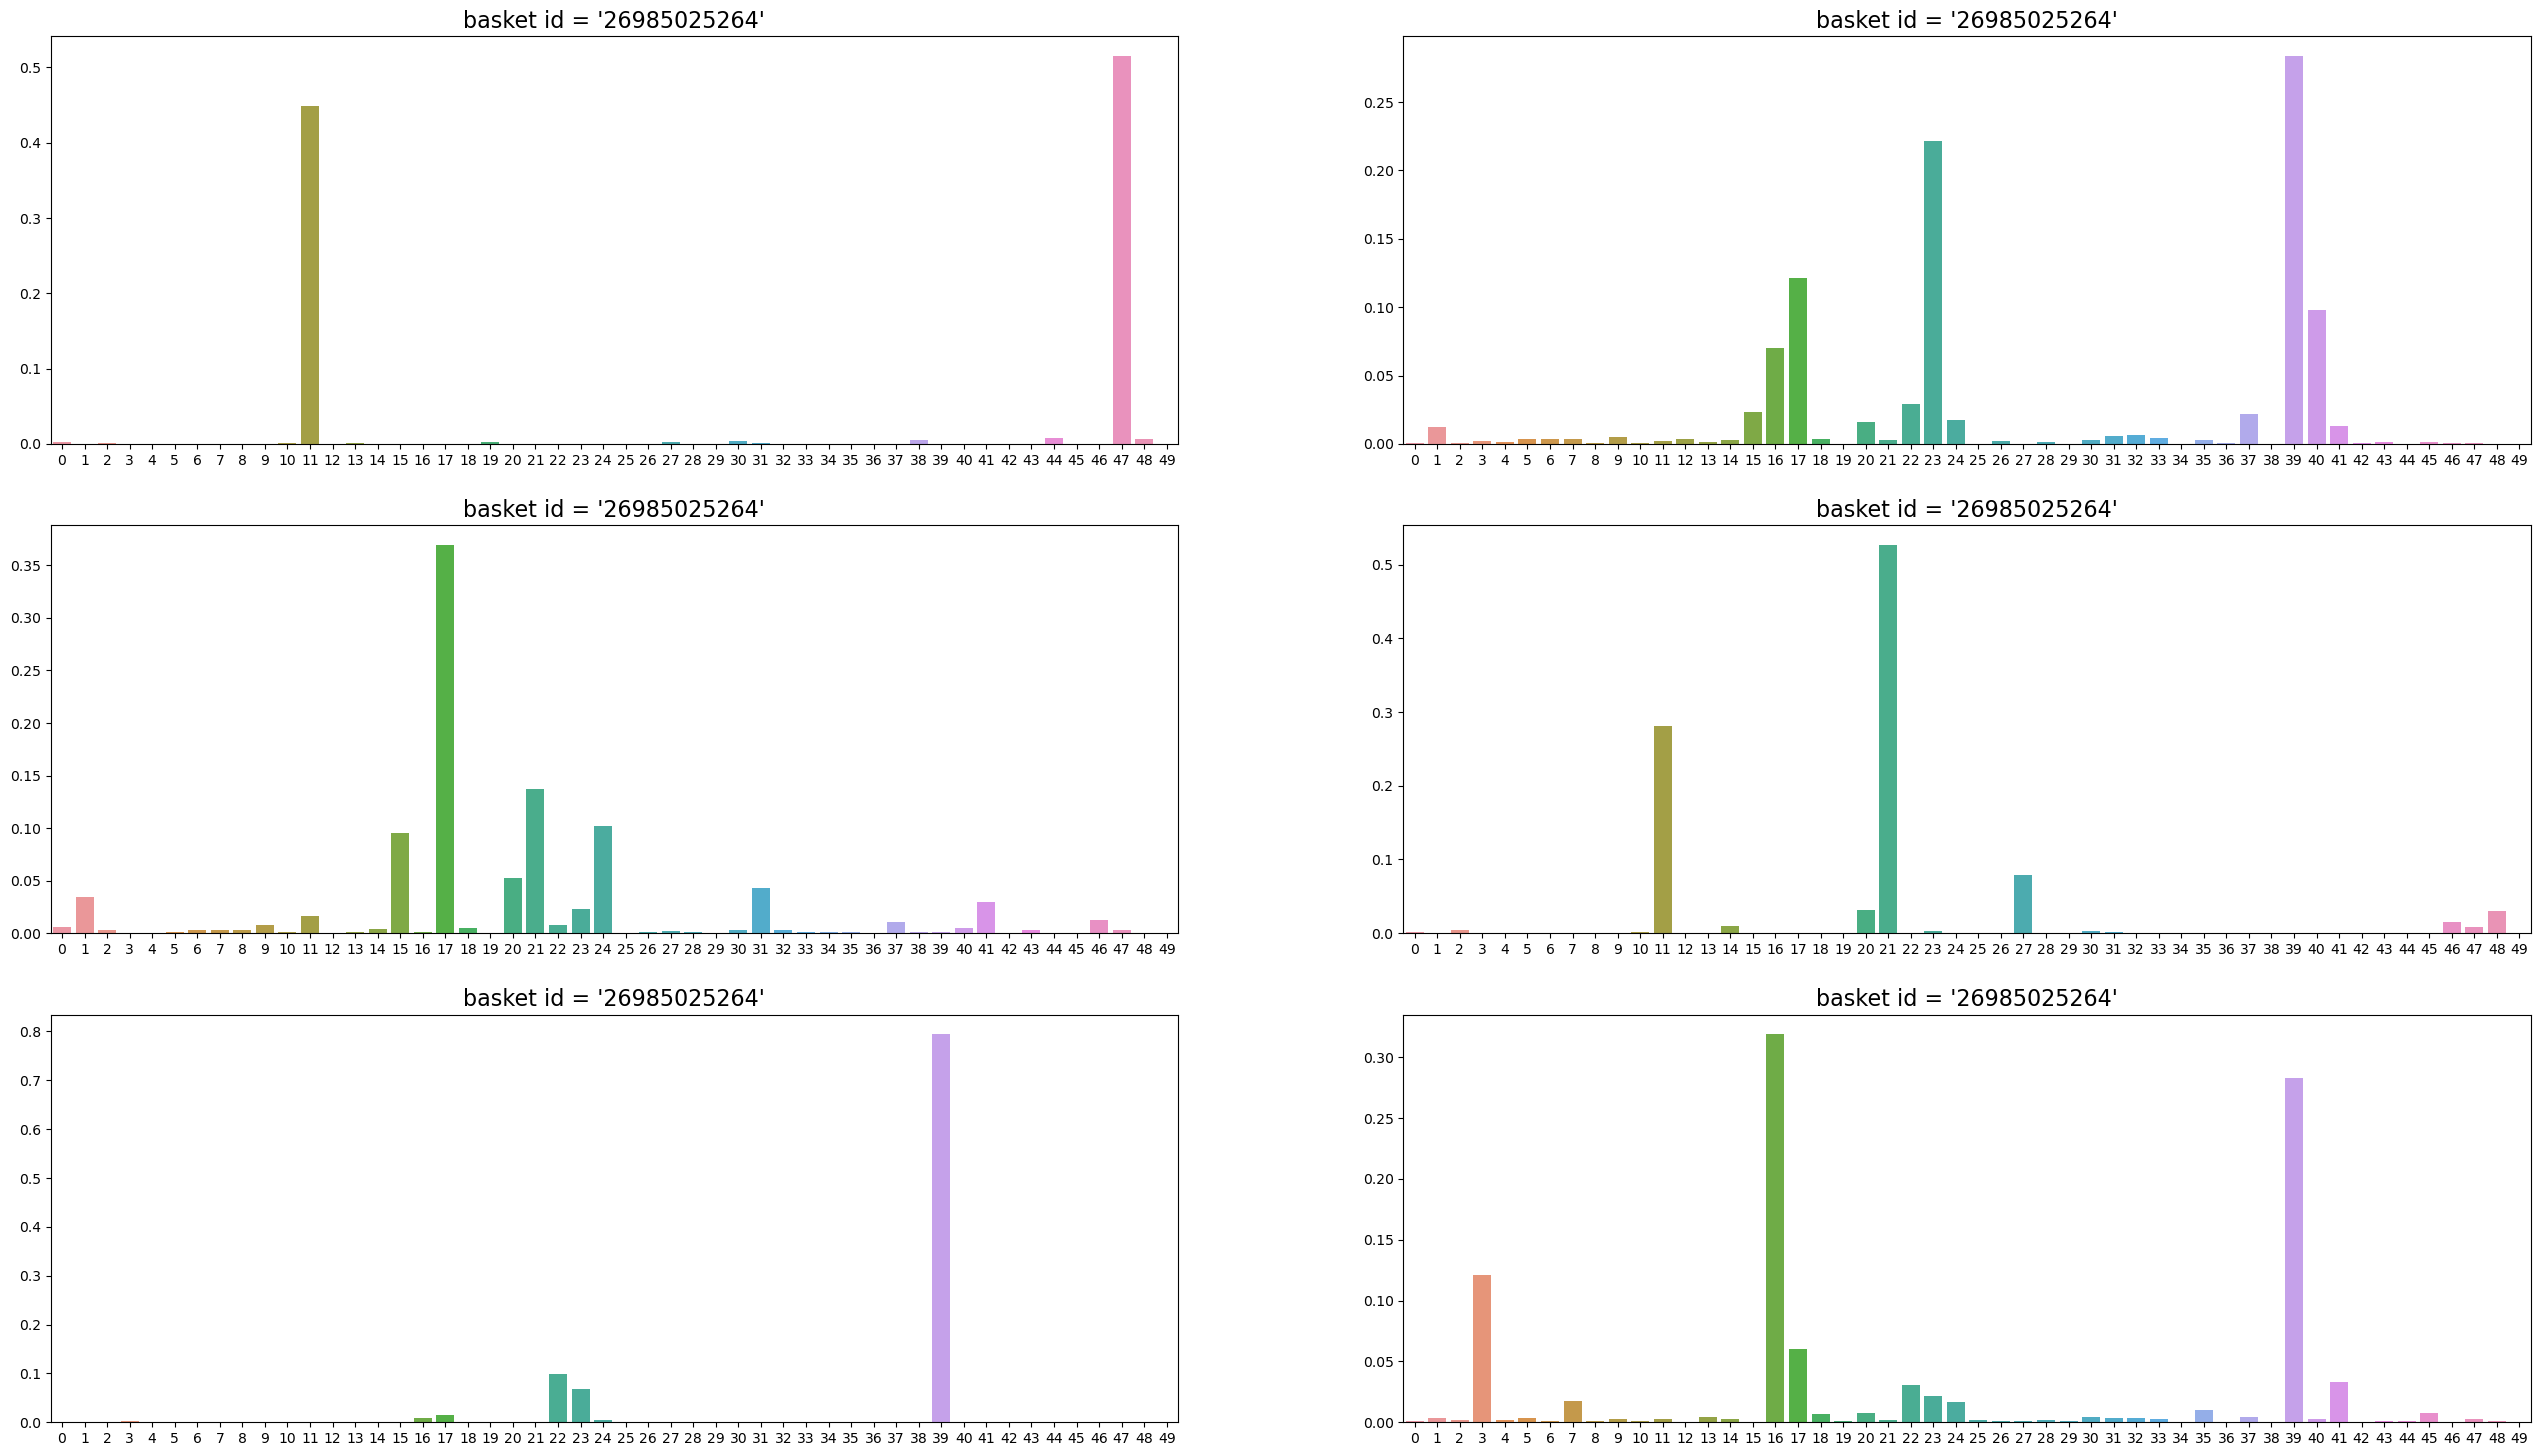

In [46]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32, 18))
for i in range(6):
    sns.barplot(x=list(range(best_gamma.shape[1])), y=best_gamma[i], ax=axes[(i//2)][i%2])
    axes[(i//2)][i%2].set_title("basket id = '%s'" % train_grocery_df.BASKET_ID[:6][i], size=16)

plt.show()


__Compute global product purchase probabilities__

In [47]:
product_counts = train_grocery_df.groupby('PRODUCT_ID')['QUANTITY'].sum()
product_purchase_prob = product_counts / product_counts.sum()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

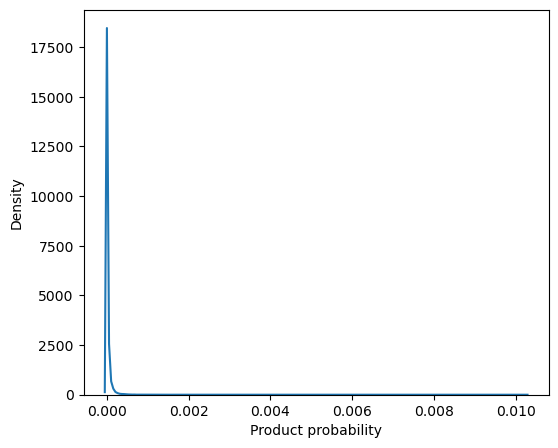

In [48]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(product_purchase_prob, ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [49]:
global_probs_df = pd.DataFrame(data={'Product probability': product_purchase_prob}).sort_values('Product probability', ascending=False)
import dataframe_image as dfi
dfi.export(global_probs_df.head(), "train_grocery_df_head.png")

In [50]:
high_freq_items_prob = product_purchase_prob[product_purchase_prob > 0.0001]
high_freq_items_prob_df = pd.DataFrame(data={'Total purchase prob': high_freq_items_prob})
high_freq_items_prob_df.sort_values('Total purchase prob', ascending=False)

Total purchase prob
PRODUCT_ID                     
995242                 0.010237
1029743                0.007635
1133018                0.005806
981760                 0.005225
1106523                0.005187
...                         ...
9553382                0.000101
903609                 0.000101
943858                 0.000101
943362                 0.000101
862651                 0.000101

[2019 rows x 1 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Product probability')

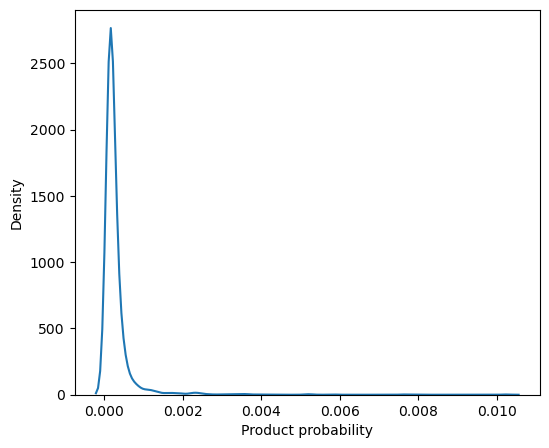

In [51]:
fig, ax = plt.subplots(figsize=(6,5))
sns.kdeplot(high_freq_items_prob_df['Total purchase prob'], ax=ax)
ax.legend().remove()
ax.set_xlabel('Product probability')

In [52]:
total_cluster_weights = best_gamma.sum(axis=0)

##products_filepath = '/home/adrien/Téléchargements/dunnhumby/product.csv'
products_filepath = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\data\product.csv"

products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)

cluster_weights_by_basket_id = {}
for i, (individual_id, basket_id) in enumerate(train_counts_df.index):
    cluster_weights_by_basket_id[basket_id] = best_gamma[i]

def product_prob_for_component(g, k):
    total_product_cluster_weight = 0
    for basket_id in g['BASKET_ID']:
        total_product_cluster_weight += cluster_weights_by_basket_id[basket_id][k]
    return total_product_cluster_weight / total_cluster_weights[k]

def get_high_lift_frequent_items(k):
    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift.join(products_df, how='inner')

In [53]:
# Assuming 'QUANTITY' is a numeric column in train_grocery_df
total_quantities = train_grocery_df['QUANTITY'].sum()


cluster_1_df = get_high_lift_frequent_items(k=0)

cluster_1_df['count'] = (cluster_1_df['Total purchase prob'] * total_quantities).astype(np.int64)
weights = (cluster_1_df['Lift'] * cluster_1_df['count']).astype(np.int64)
cluster_1_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(np.int64)


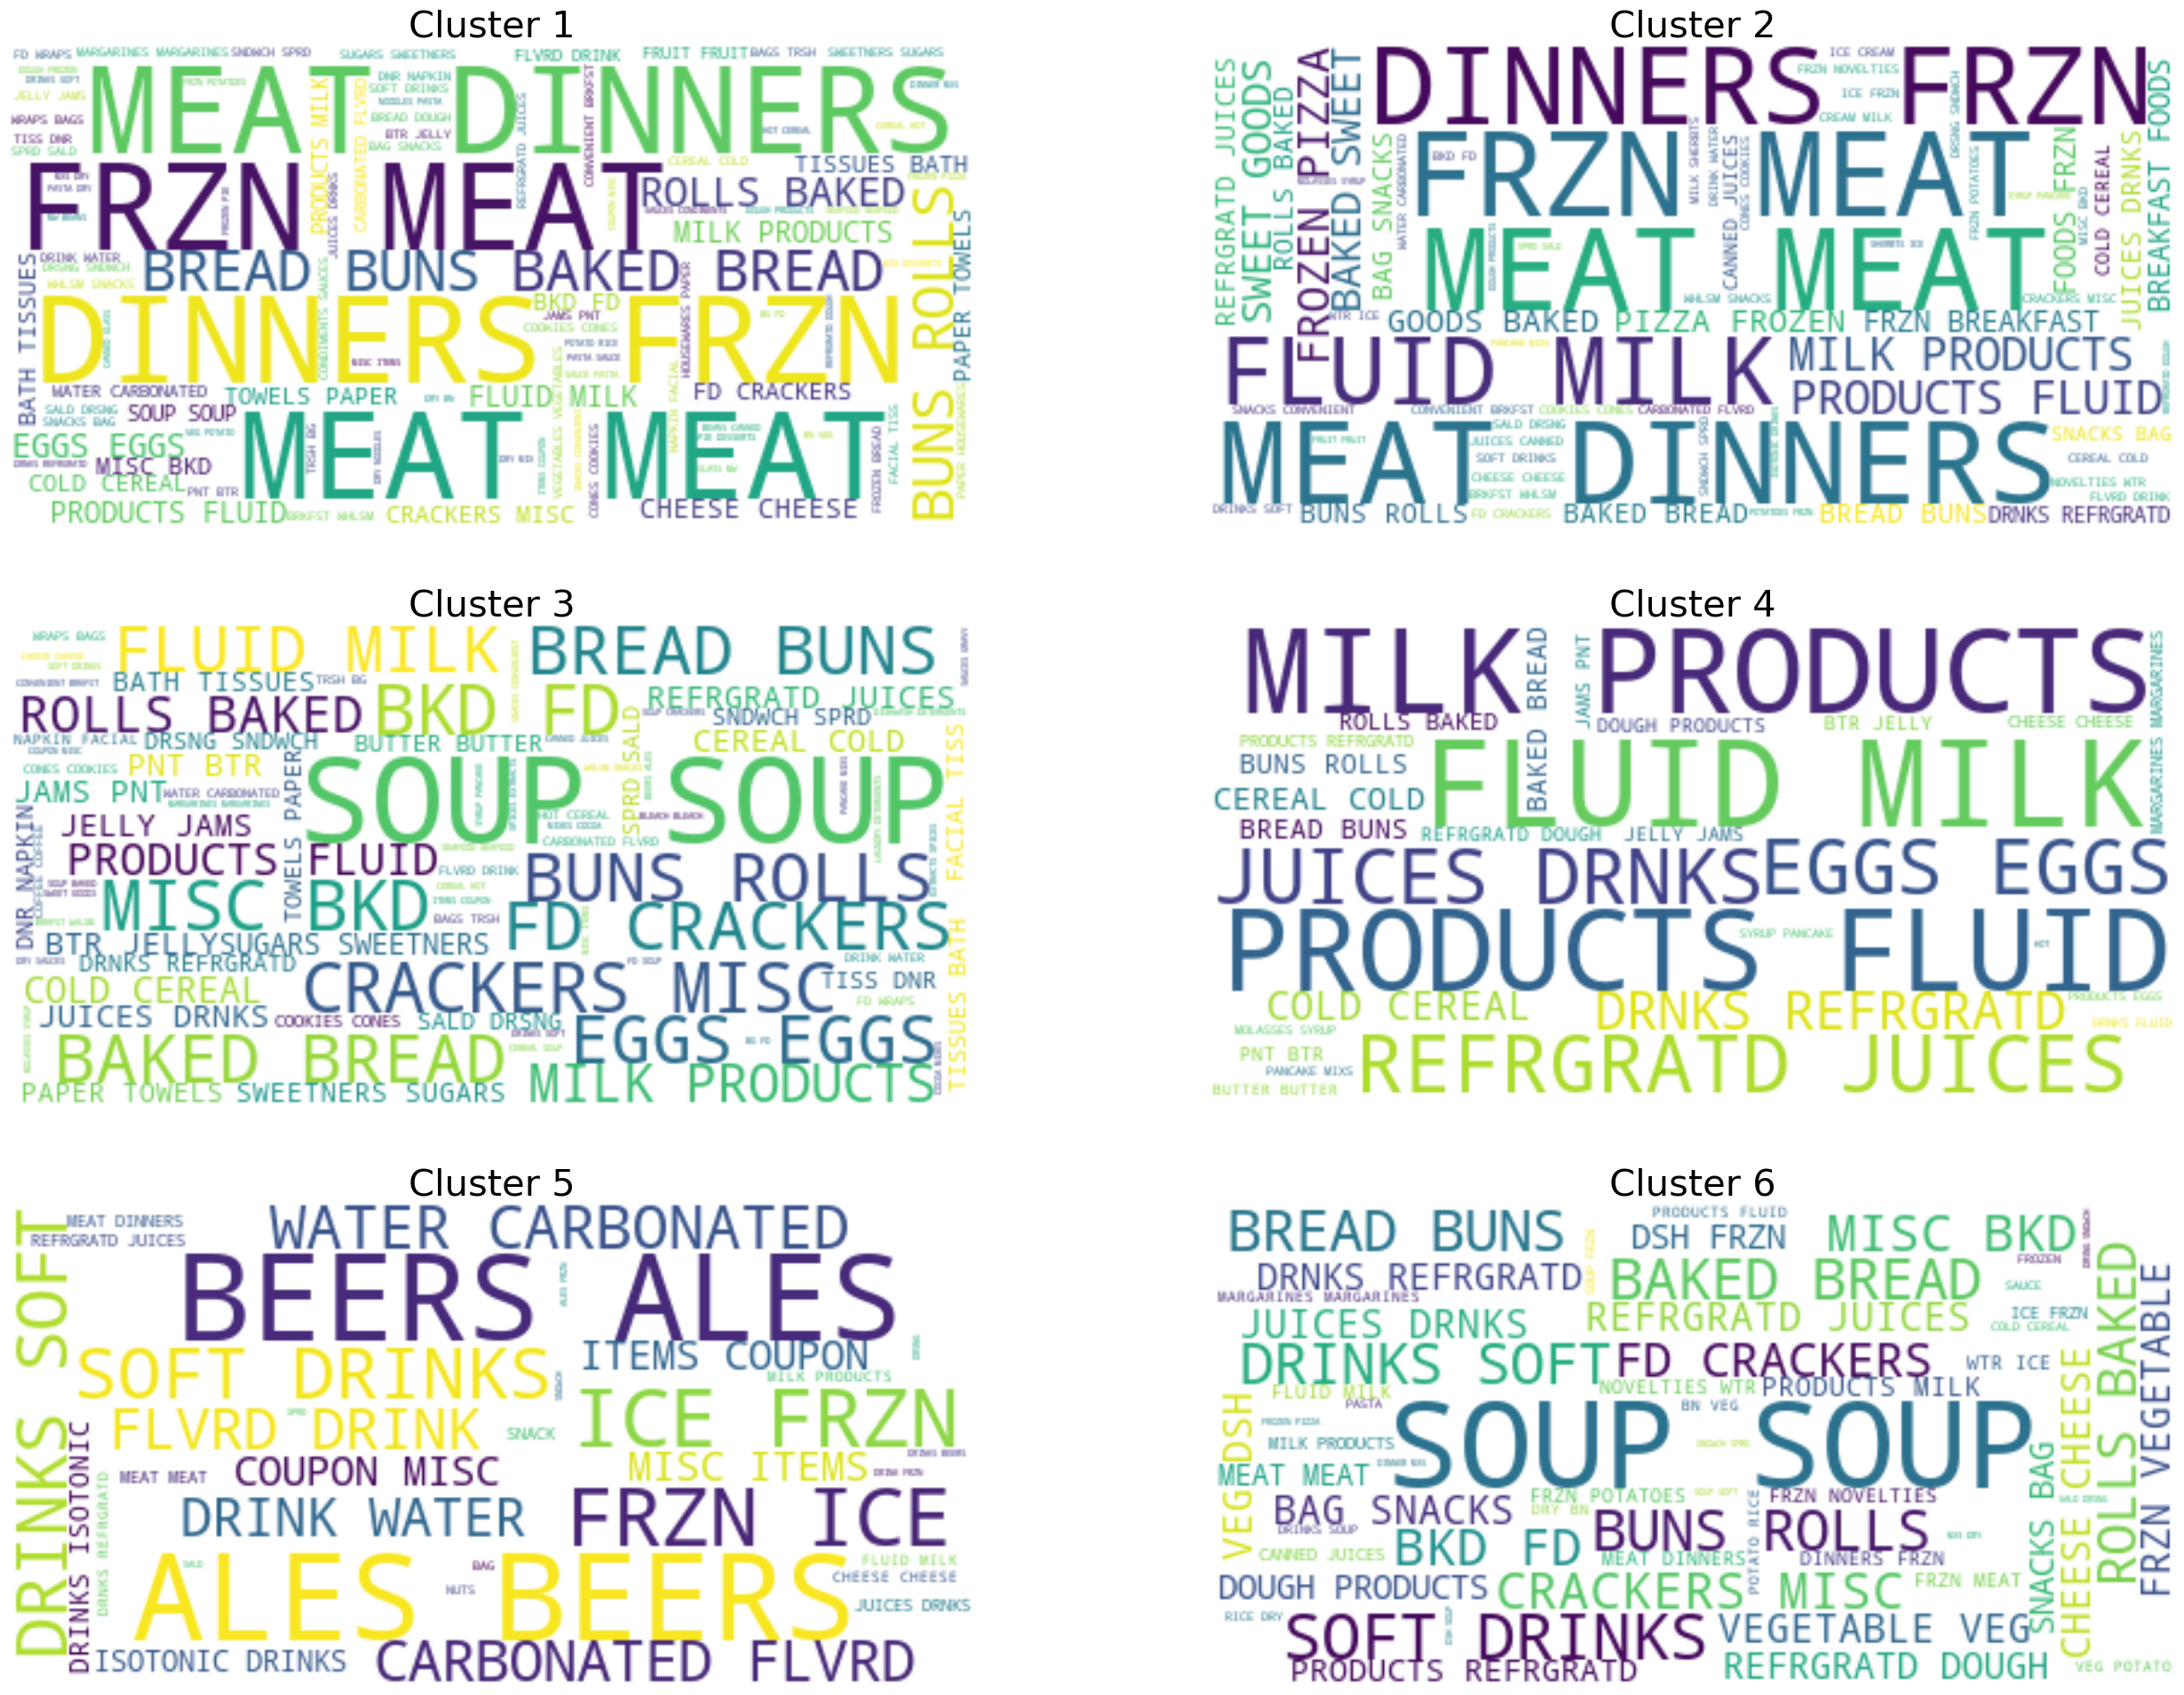

In [54]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

total_quantities = train_grocery_df['QUANTITY'].sum()

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white")
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(32, 24))
axes = axes.ravel()

for i, ax in enumerate(axes):
    high_lift_items_df = get_high_lift_frequent_items(k=i)
    high_lift_items_df['count'] = (high_lift_items_df['Total purchase prob'] * total_quantities).astype(np.int64)  # Use np.int64
    weights = (high_lift_items_df['Lift'] * high_lift_items_df['count']).astype(np.int64)  # Use np.int64
    high_lift_items_df['repeat_weight'] = (((weights - weights.min()) / (weights.max() - weights.min())) * 100).astype(np.int64)  # Use np.int64
    high_lift_items_df['COMMODITY_DESC'] = (high_lift_items_df['COMMODITY_DESC'] + ', ').str.replace('SHELF', '').str.replace('STABLE', '')
    description = high_lift_items_df['COMMODITY_DESC'].repeat(high_lift_items_df['repeat_weight']).str.cat(sep=', ')
    img = wordcloud.generate(description)
    ax.imshow(img, interpolation="bilinear")
    ax.axis("off")
    ax.set_title('Cluster %i' % (i + 1), size=30)

plt.show()

### Now product associations

In [55]:
cluster_1_df.sort_values('Lift', ascending=False)

Total purchase prob        Lift  MANUFACTURER DEPARTMENT  \
PRODUCT_ID                                                             
1019883                0.000117  106.666162          1807    GROCERY   
943858                 0.000101  100.417433          5569    GROCERY   
1135460                0.000138   95.076870          1807    GROCERY   
1065061                0.000107   92.144196           151    GROCERY   
897953                 0.000122   92.022999          1807    GROCERY   
...                         ...         ...           ...        ...   
936594                 0.000447   10.020896           843    GROCERY   
964262                 0.000129   10.016716          2143    GROCERY   
6464165                0.000116   10.016621            69    GROCERY   
12263279               0.000109   10.013277          1487    GROCERY   
13945244               0.000121   10.010411           492    GROCERY   

               BRAND             COMMODITY_DESC  \
PRODUCT_ID                                        
1019883     National     FRZN MEAT/MEAT DINNERS   
943858      National     FRZN MEAT/MEAT DINNERS   
1135460     National     FRZN MEAT/MEAT DINNERS   
1065061     National     FRZN MEAT/MEAT DINNERS   
897953      National     FRZN MEAT/MEAT DINNERS   
...              ...                        ...   
936594      National  BEANS - CANNED GLASS & MW   
964262      National          DRY NOODLES/PASTA   
6464165      Private     ICE CREAM/MILK/SHERBTS   
12263279    National                     YOGURT   
13945244    National           MILK BY-PRODUCTS   

                        SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  count  \
PRODUCT_ID                                                               
1019883     FRZN SS PREMIUM ENTREES/DNRS/N                 8 OZ    202   
943858      SS ECONOMY ENTREES/DINNERS ALL               8.5 OZ    174   
1135460     FRZN SS PREMIUM ENTREES/DNRS/N               8.5 OZ    239   
1065061     FRZN SS PREMIUM ENTREES/DNRS/T              10.5 OZ    185   
897953      FRZN SS PREMIUM ENTREES/DNRS/N               8.6 OZ    211   
...                                    ...                  ...    ...   
936594       PREPARED BEANS - BAKED W/PORK                28 OZ    773   
964262                        MACARONI DRY                16 OZ    224   
6464165                            PREMIUM                56 OZ    201   
12263279            YOGURT NOT MULTI-PACKS                 8 OZ    189   
13945244                       REFRIG DIPS                16 OZ    209   

            repeat_weight  
PRODUCT_ID                 
1019883                18  
943858                 14  
1135460                19  
1065061                14  
897953                 16  
...                   ...  
936594                  5  
964262                  0  
6464165                 0  
12263279                0  
13945244                0  

[804 rows x 10 columns]

In [56]:
import itertools

cluster1_highest_lift_product_ids = cluster_1_df.sort_values('Lift', ascending=False).index[:5]
cluster1_highest_lift_product_pairs = list(itertools.combinations(cluster1_highest_lift_product_ids, 2))
len(cluster1_highest_lift_product_pairs)

10

In [57]:
from tqdm import tqdm
from collections import defaultdict

nb_baskets = len(train_grocery_df['BASKET_ID'].unique())
total_cluster_weight = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in train_grocery_df['BASKET_ID'].unique()])

basket_ids_with_pair_by_pair = defaultdict(list)
for i, g in tqdm(train_grocery_df.groupby('BASKET_ID')):
    for pair in cluster1_highest_lift_product_pairs:
        if ((g['PRODUCT_ID'] == pair[0]).sum() > 0) and ((g['PRODUCT_ID'] == pair[1]).sum() > 0):
            basket_ids_with_pair_by_pair[pair].append(g['BASKET_ID'].iloc[0])

pair_lifts = {}
for pair, basket_ids in basket_ids_with_pair_by_pair.items():
    total_proba = len(basket_ids) / nb_baskets
    cluster_pair_proba = sum([cluster_weights_by_basket_id[basket_id][0] for basket_id in basket_ids]) / total_cluster_weight
    pair_lifts[pair] = cluster_pair_proba / total_proba    

100%|██████████| 172328/172328 [03:06<00:00, 924.42it/s]


In [58]:
pair_lifts

{(1019883, 1135460): 18.694591456009658,
 (1019883, 897953): 13.517449319900102,
 (1135460, 897953): 15.210686572080355,
 (943858, 897953): 50.85024749563086,
 (1019883, 1065061): 40.82529432613301,
 (1135460, 1065061): 6.092226954654691}

In [59]:
products_df[(products_df.index == 820361) | (products_df.index == 965719)]

MANUFACTURER DEPARTMENT     BRAND             COMMODITY_DESC  \
PRODUCT_ID                                                                 
820361              1557    GROCERY  National  BEANS - CANNED GLASS & MW   
965719                69    GROCERY   Private  VEGETABLES - SHELF STABLE   

                      SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                                                     
820361      VARIETY BEANS - KIDNEY PINTO              15.5 OZ  
965719                      TOMATO SAUCE                29 OZ

### Predictive profiles

__Global predictive profile__

<Axes: >

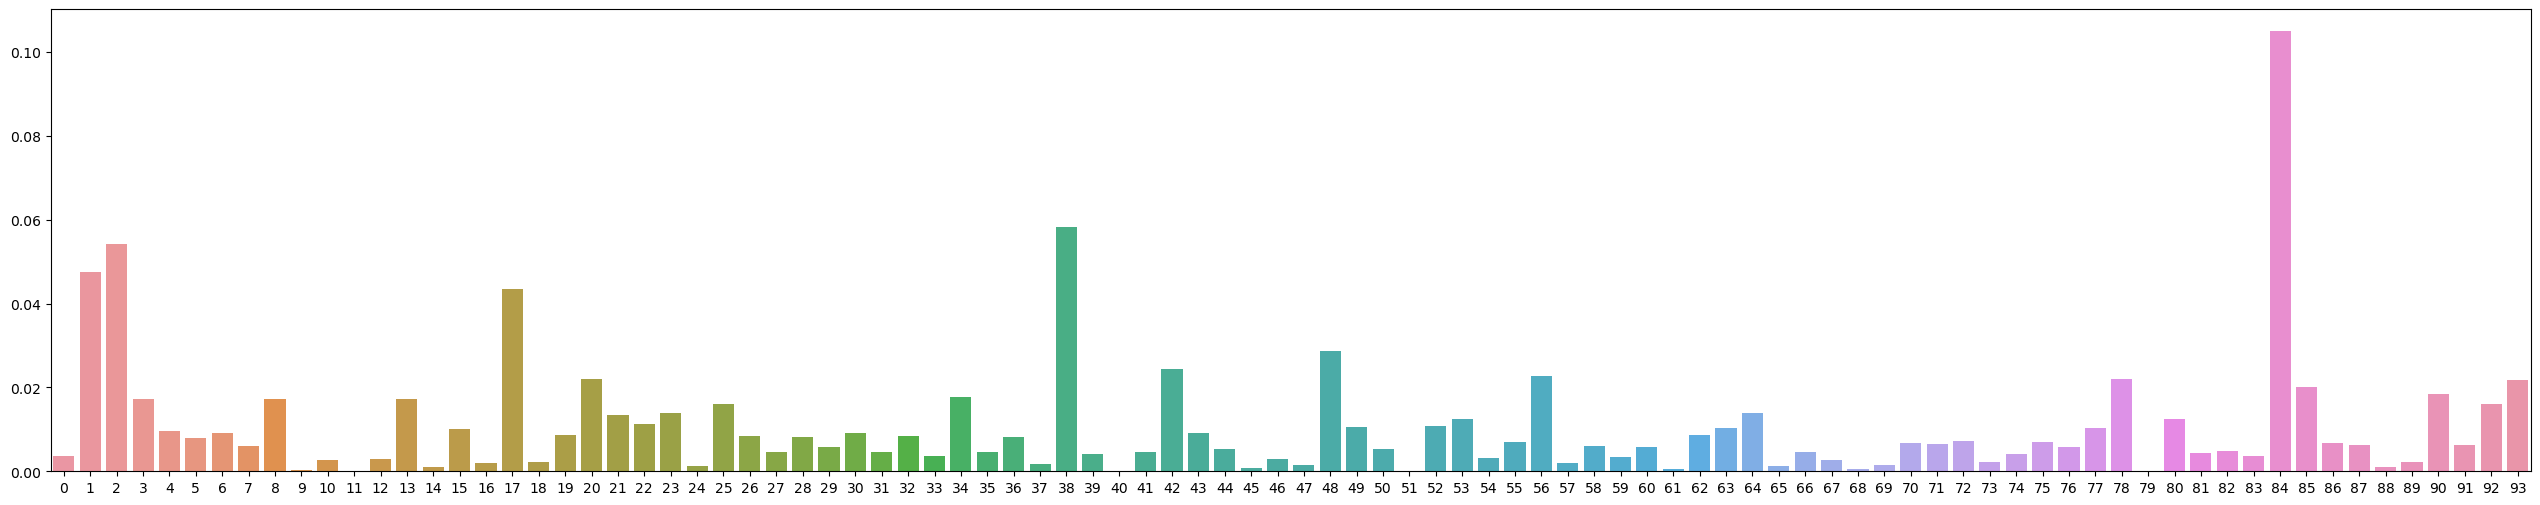

In [60]:
weighted_multi = best_alpha.reshape(-1, 1) * best_beta
global_predictive_profile = weighted_multi.sum(axis=0) / weighted_multi.sum()

plt.subplots(figsize=(32,6))
sns.barplot(x=np.arange(best_beta.shape[1]), y=global_predictive_profile)

__same thing by sampling__

Text(0, 0.5, 'Purchase probability')

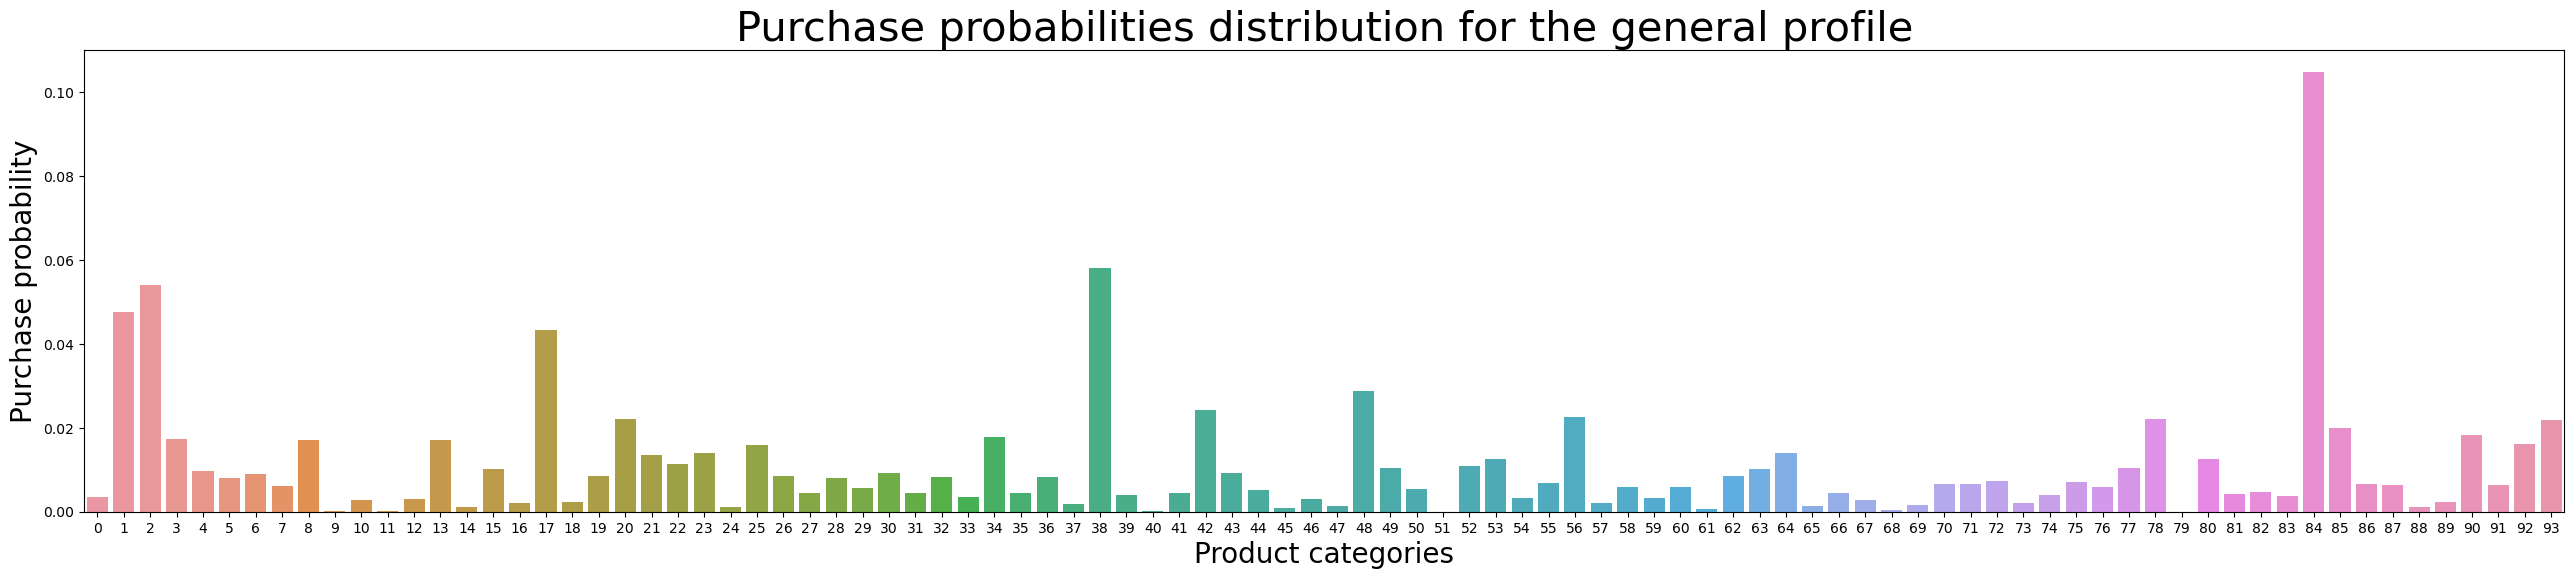

In [61]:
from scipy.stats import multinomial

K, C = best_beta.shape
n=100000
total = np.zeros((C))
for k in range(K):
    k_samples = best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=1000)
    total += k_samples.sum(axis=0)
probs = total / total.sum()

plt.subplots(figsize=(32,6))
ax = sns.barplot(x=np.arange(probs.size), y=probs)
ax.set_title('Purchase probabilities distribution for the general profile', size=30)
ax.set_xlabel('Product categories', size=20)
ax.set_ylabel('Purchase probability', size=20)

__Now using cluster assignments__

In [62]:
best_gamma_df = pd.DataFrame(best_gamma, index=train_household_ids)
best_gamma_df.head()

0         1         2             3             4   \
household_key                                                             
1              0.002219  0.000011  0.000929  4.964843e-09  4.535301e-11   
1              0.000740  0.012203  0.000837  2.232126e-03  1.442807e-03   
1              0.005929  0.034238  0.003285  2.379939e-04  2.285812e-04   
1              0.001985  0.000006  0.004655  9.671442e-09  1.994043e-09   
1              0.000064  0.001178  0.000119  2.676107e-03  1.430497e-05   

                         5         6             7         8         9   ...  \
household_key                                                            ...   
1              2.899104e-06  0.000019  1.375667e-09  0.000058  0.000002  ...   
1              3.410789e-03  0.003243  3.940853e-03  0.001032  0.004759  ...   
1              9.301085e-04  0.003374  2.948387e-03  0.002877  0.007506  ...   
1              3.409647e-09  0.000001  6.539174e-09  0.000013  0.000141  ...   
1              1.063390e-04  0.000065  3.994928e-04  0.000042  0.000202  ...   

                         40            41        42            43        44  \
household_key                                                                 
1              4.514110e-14  8.948345e-07  0.000160  7.843547e-07  0.007667   
1              9.776067e-02  1.346817e-02  0.000325  1.330799e-03  0.000163   
1              5.174354e-03  2.986783e-02  0.000354  3.204020e-03  0.000434   
1              9.361020e-11  3.647422e-05  0.000243  6.718111e-05  0.000031   
1              1.146502e-05  1.498940e-03  0.000006  1.019922e-04  0.000004   

                     45        46        47        48            49  
household_key                                                        
1              0.000003  0.000097  0.515449  0.006505  2.553683e-04  
1              0.001325  0.000547  0.001037  0.000132  9.331248e-05  
1              0.000361  0.012672  0.002944  0.000488  2.286225e-04  
1              0.000003  0.014864  0.007866  0.030507  5.521928e-05  
1              0.000098  0.000038  0.000137  0.000007  4.785955e-07  

[5 rows x 50 columns]

In [63]:
test_counts_df.index = test_counts_df.index.droplevel()

In [64]:
from scipy.special import logsumexp

def compute_complete_predictive_profile(household_key):
    household_assignments = best_gamma_df[best_gamma_df.index == household_key]

    K, C = best_beta.shape
    total = np.zeros(C)
    for i, assignment in household_assignments.iterrows():
        for k in range(assignment.size):
            i_k_samples = assignment[k] * best_alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=100)
            total += i_k_samples.sum(axis=0)
    probs = total / total.sum()
    return probs
    
def compute_household_test_purchase(household_key):
    test_basket_ids=test_grocery_df.loc[test_grocery_df['household_key'] == household_key, 'BASKET_ID'].unique()
    household_test_counts_df = test_counts_df[test_counts_df.index.isin(test_basket_ids)].sum(axis=0)
    return household_test_counts_df / household_test_counts_df.sum()
    
def plot_prediction_vs_reality(household_key):
    fig, axes = plt.subplots(nrows=2, figsize=(32,14))
    axes = axes.ravel()
    
    predictive_probs = compute_complete_predictive_profile(household_key)
    sns.barplot(x=np.arange(predictive_probs.size), y=predictive_probs, ax=axes[0])
    axes[0].set_title('Purchases probabilities prediction for household %s' % str(household_key), size=20)
    axes[0].set_xlabel('Categories', size=20)
    axes[0].set_ylabel('Probability', size=20)

    test_probs = compute_household_test_purchase(household_key)
    sns.barplot(x=np.arange(test_probs.size), y=test_probs, ax=axes[1])
    axes[1].set_title('Purchases from the test set for household %s' % str(household_key), size=20)
    axes[1].set_xlabel('Categories', size=20)
    axes[1].set_ylabel('Probability', size=20)

    l1_distance = np.abs(predictive_probs - test_probs).sum()
    plt.text(0.5, -0.25, 'L1 distance between prediction and test data: %.3f' % l1_distance,
             horizontalalignment='center', verticalalignment='center', transform = axes[1].transAxes, size=30)

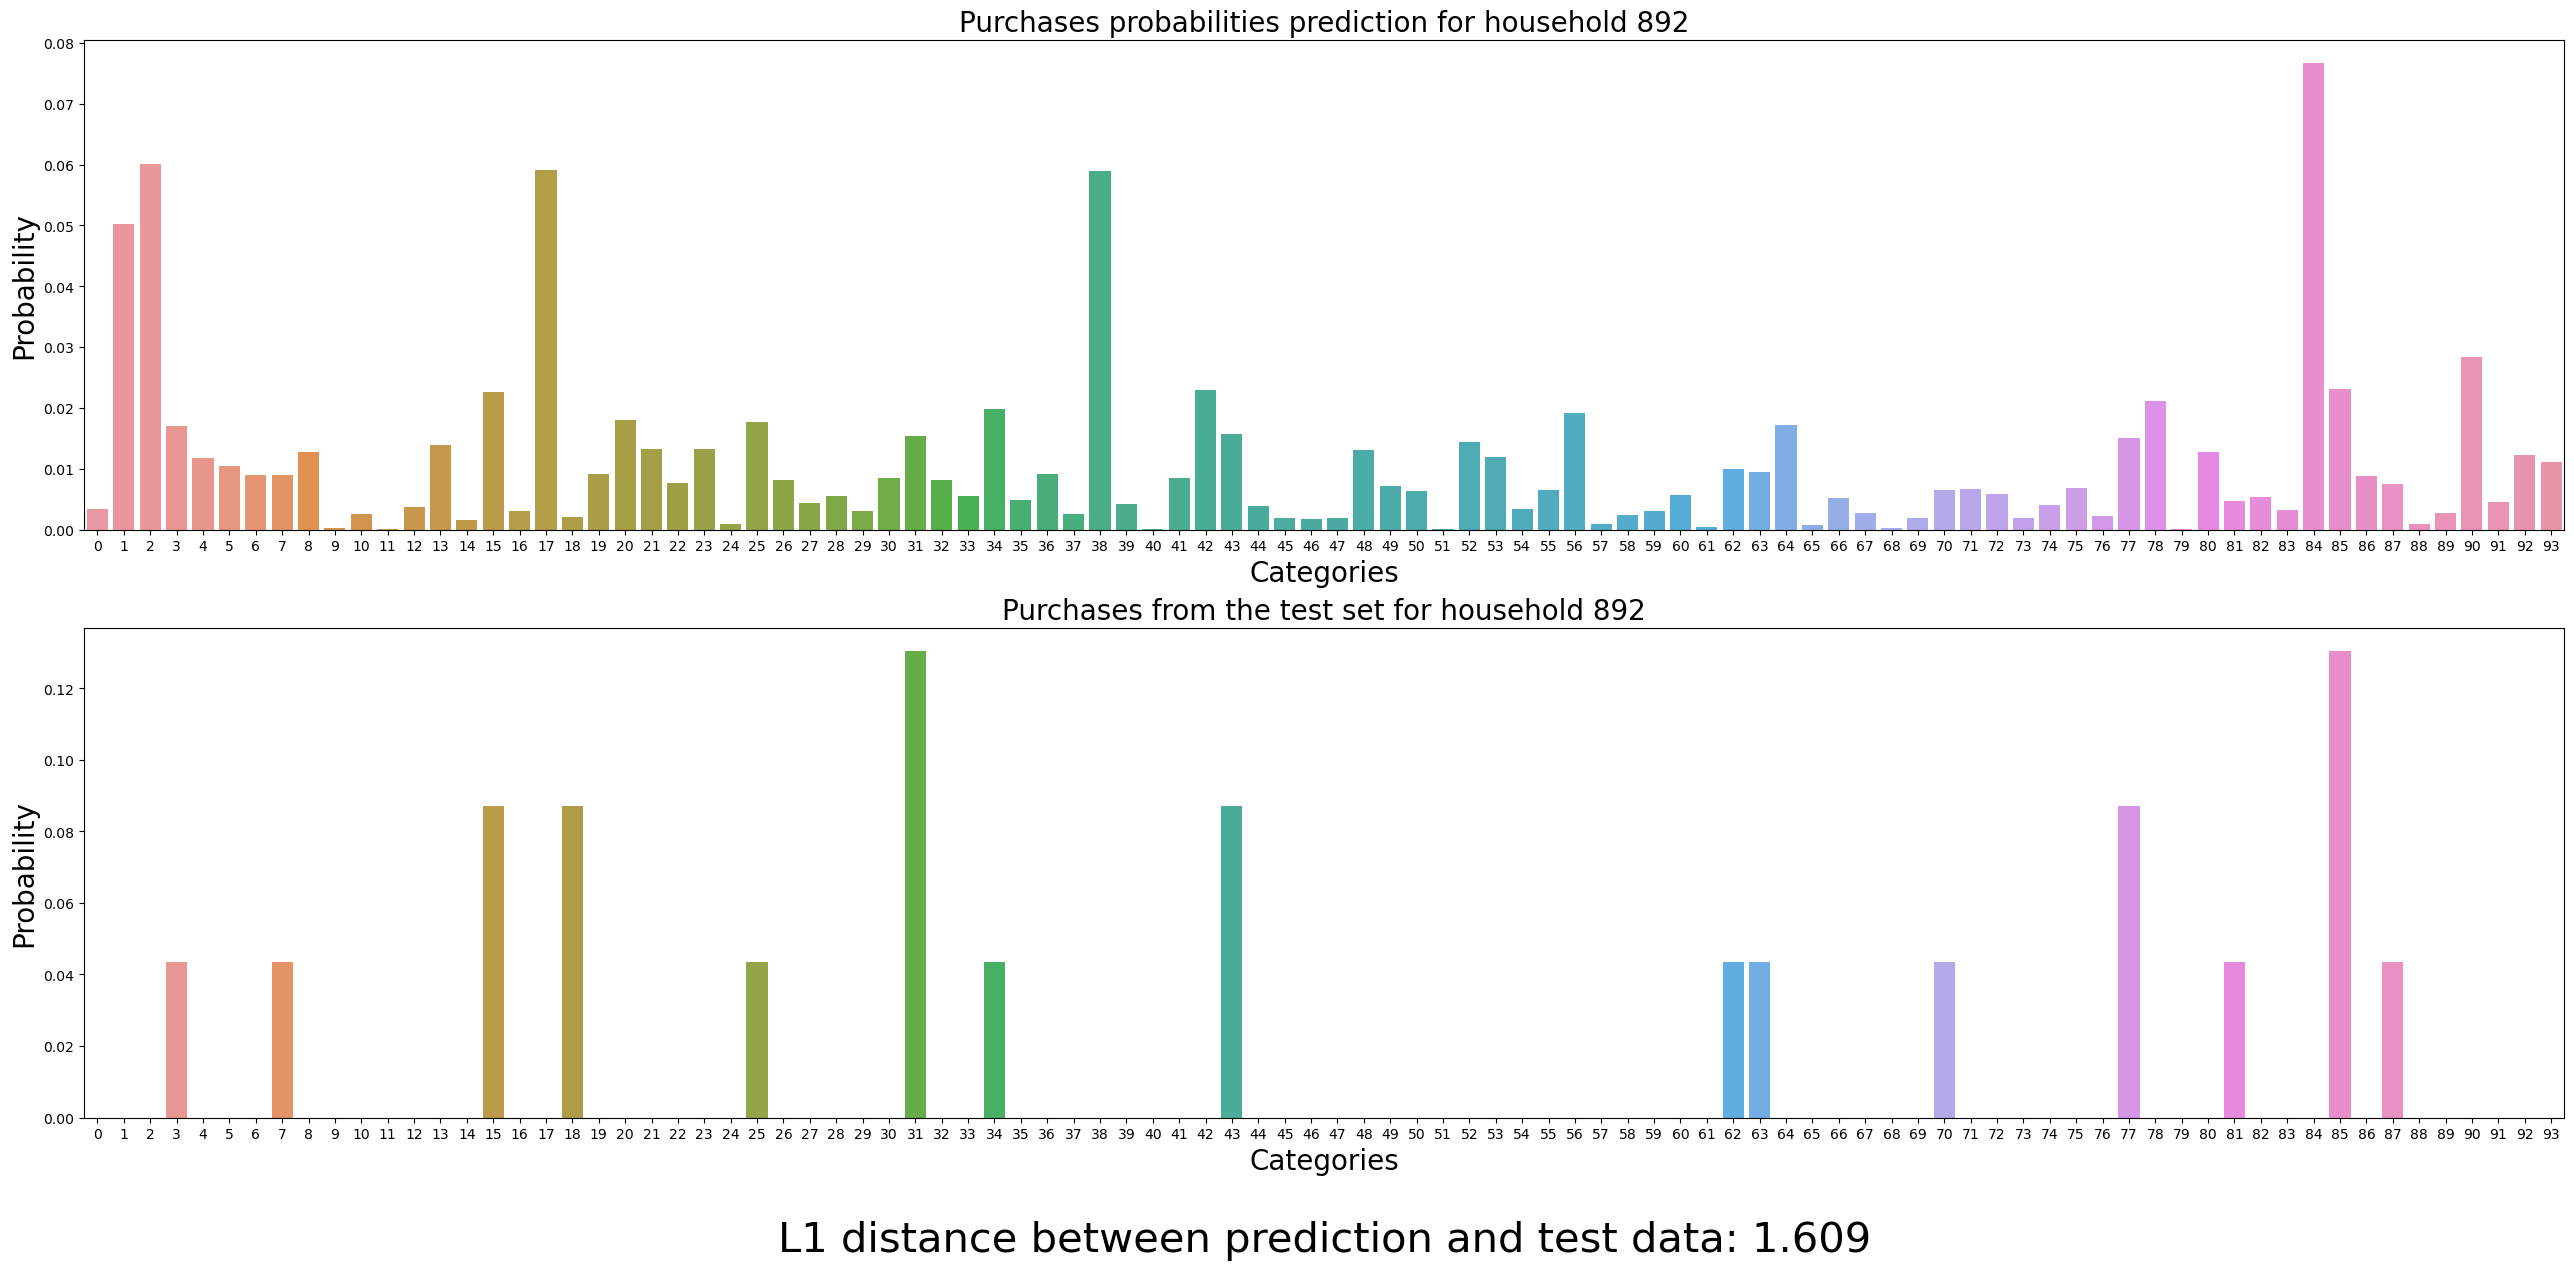

In [65]:
plot_prediction_vs_reality(892)

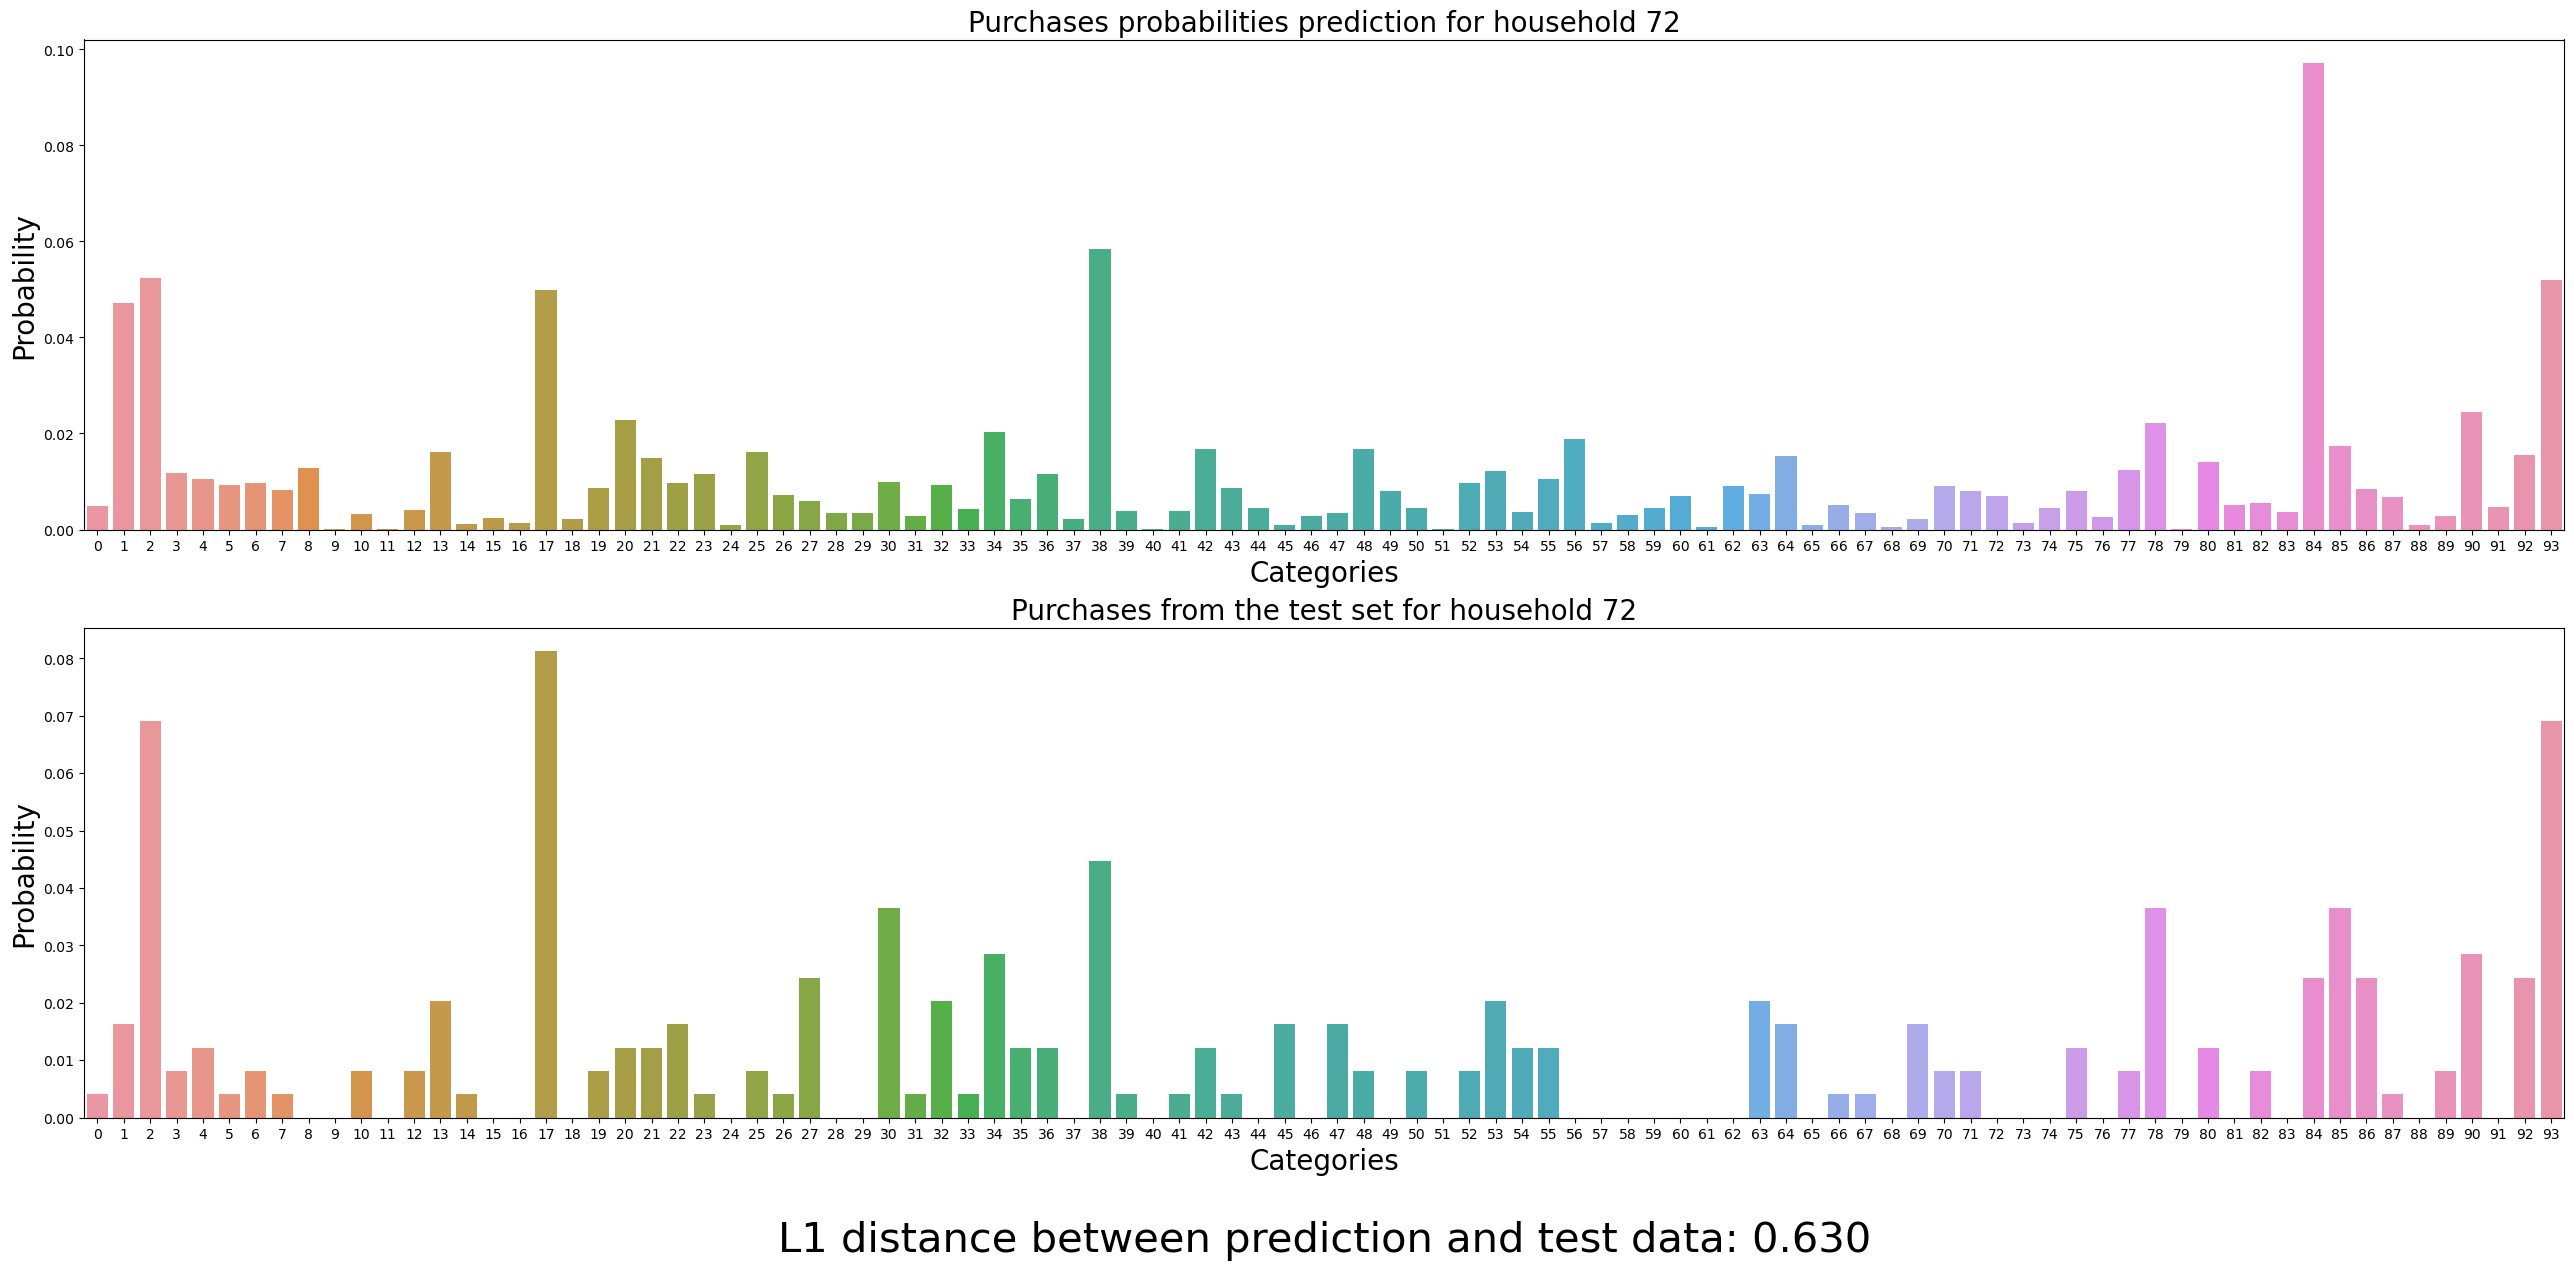

In [66]:
plot_prediction_vs_reality(72)

In [67]:
from tqdm import tqdm

unique_test_household_ids = test_grocery_df['household_key'].unique()
predictions_distances = {}
for household_id in tqdm(unique_test_household_ids):
    predictive_probs = compute_complete_predictive_profile(household_id)
    test_probs = compute_household_test_purchase(household_id)
    l1_distance = np.abs(predictive_probs - test_probs).sum()
    predictions_distances[household_id] = l1_distance

 86%|████████▋ | 2038/2361 [1:01:25<04:54,  1.10it/s]C:\Users\Tinga\AppData\Local\Temp\ipykernel_27240\3972107922.py:12: RuntimeWarning: invalid value encountered in divide
  probs = total / total.sum()
100%|██████████| 2361/2361 [1:04:45<00:00,  1.65s/it]


In [68]:
pickle.dump(predictions_distances, open('predictions_distances.p', 'wb'))

### Check individuals cluster assignments stability

In [69]:
def plot_group_clusters_attributions(household_key):
    g = best_gamma_df.groupby(best_gamma_df.index).get_group(household_key).copy()
    n, c = g.shape
    fig, axes = plt.subplots(nrows=((n+1) // 2), ncols=2, figsize=(32,64))
    for i in range(n):
        sns.barplot(x=list(range(g.shape[1])), y=g.iloc[i], ax=axes[(i//2)][i%2])
        axes[(i//2)][i%2].set_title('Visit = %i' % (i+1), size=16)

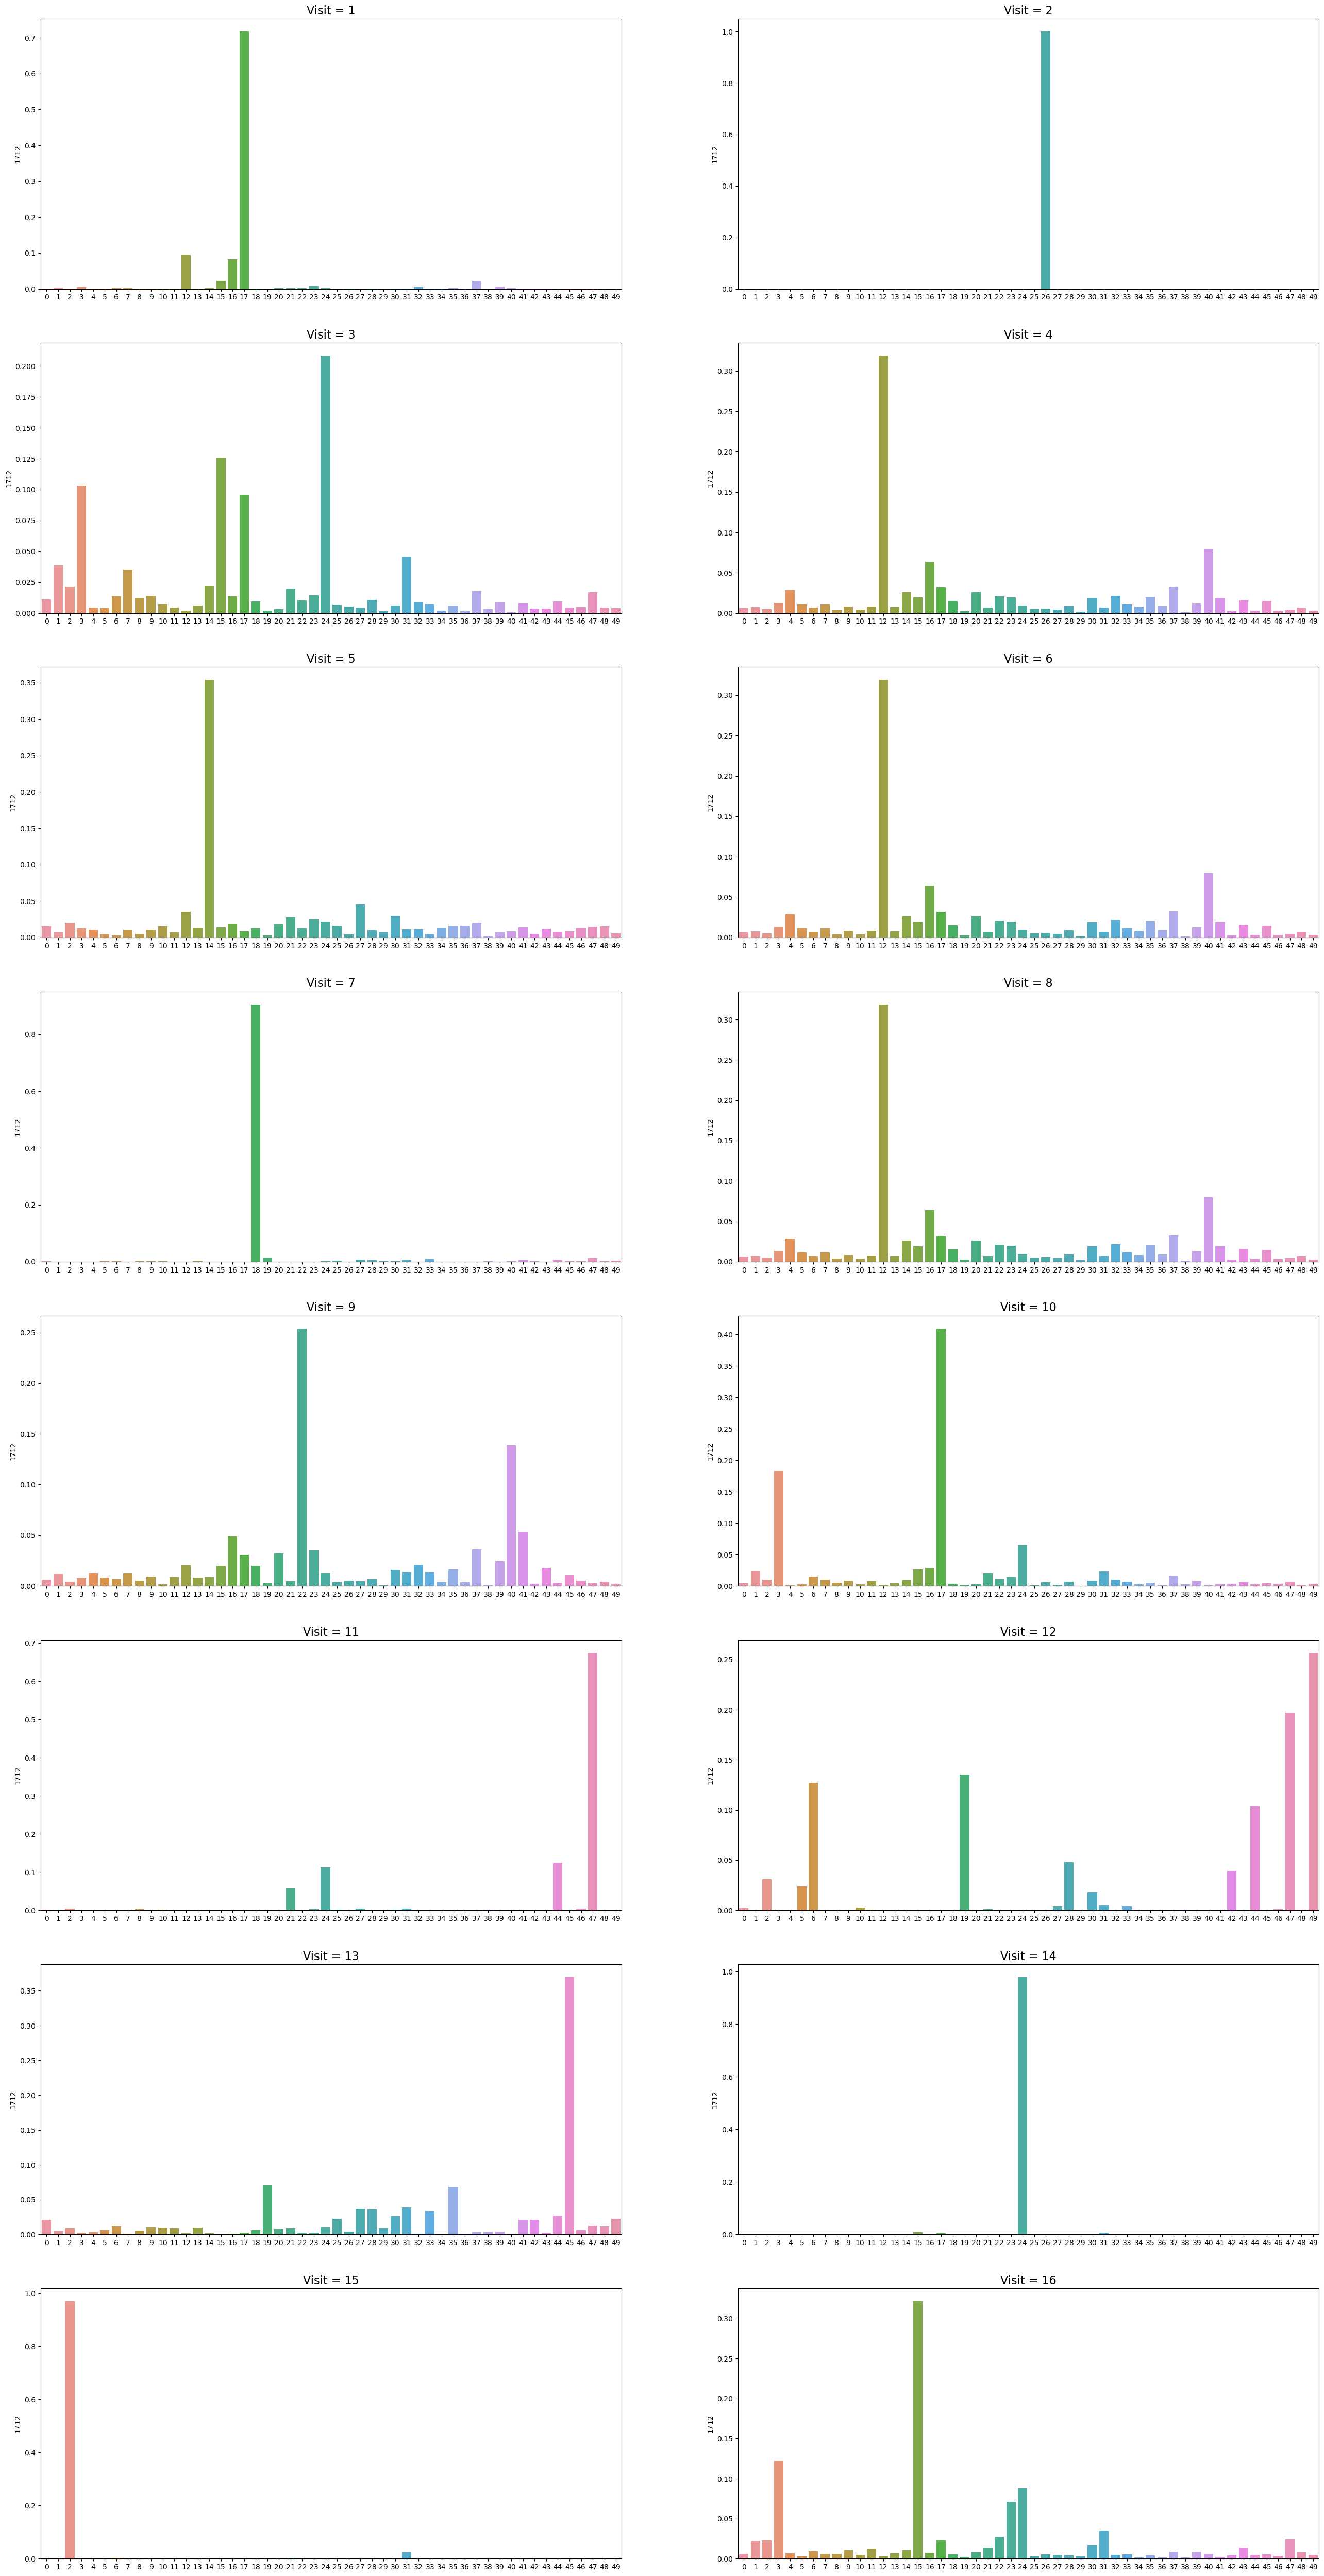

In [70]:
plot_group_clusters_attributions(1712)

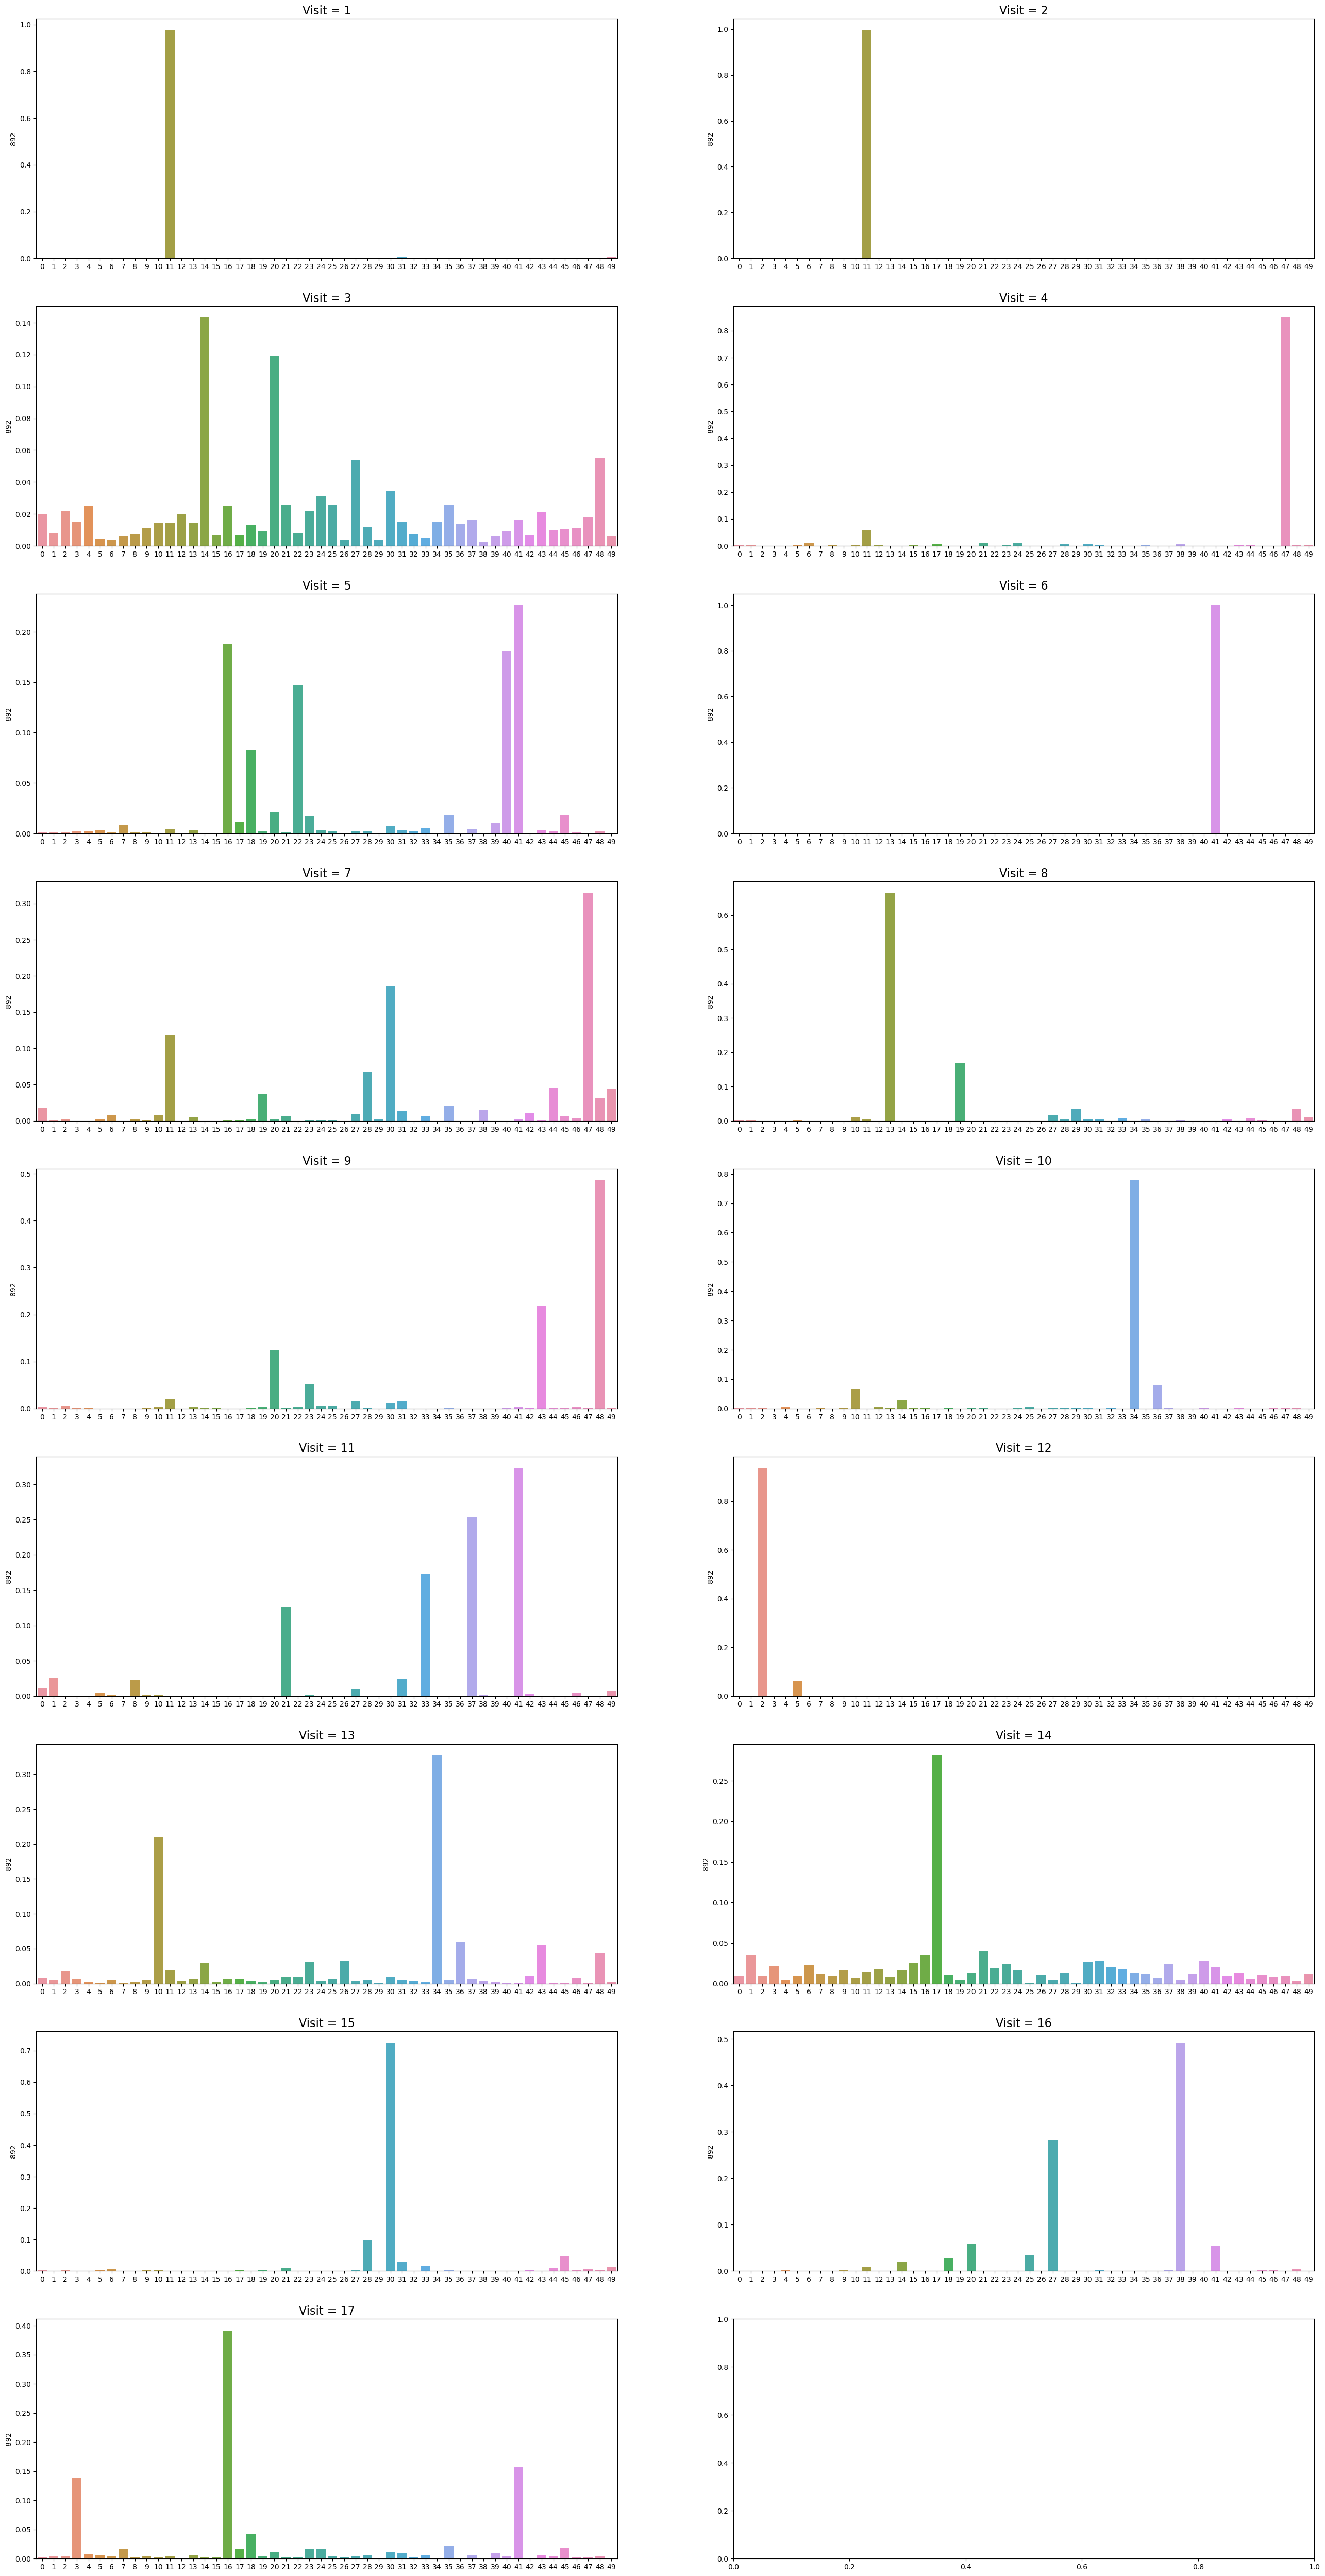

In [71]:
plot_group_clusters_attributions(892)

# __Analyze Results: Individualized Model__

In [110]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [111]:
## file_path = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_gamma\data.p"
train_grocery_df, test_grocery_df, train_counts_df, test_counts_df, train_household_ids, test_household_ids = pickle.load(open(r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_individual\data.p", 'rb'))

In [112]:
best_loss, test_log_likelihood, test_bic, best_alpha, best_beta, best_gamma = pickle.load(open(r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\run_with_individual\best_params_50.p", 'rb'))

In [113]:
test_log_likelihood

-804295.8810481158

In [114]:
test_bic

93601746.81919841

## Visualize cluster category probabilities

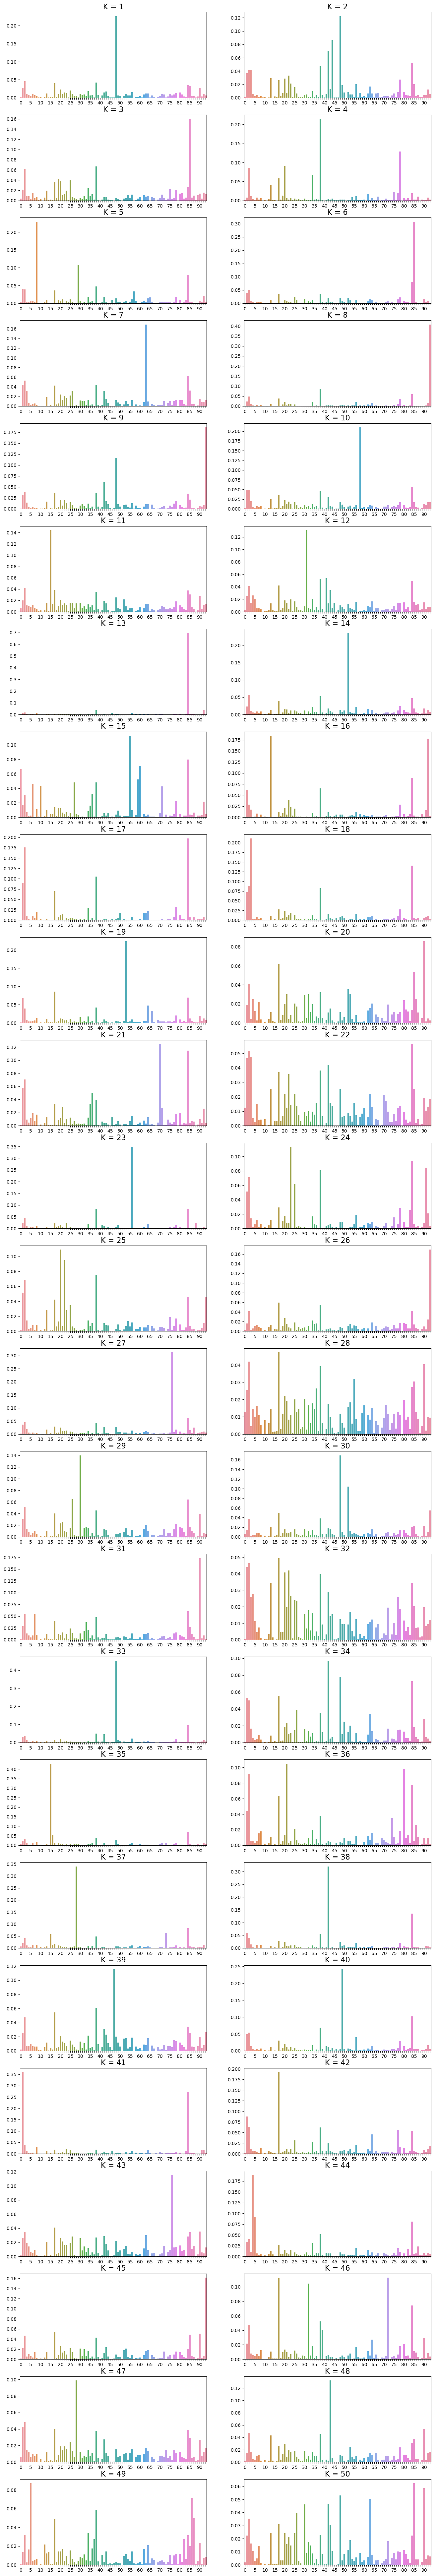

In [115]:
def hide_tick_labels(every_nth, ax):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

K, C = best_beta.shape
n_rows = ((K + 1) // 2)
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(16,n_rows*4))
axes = axes.ravel()
for k in range(K):
    sns.barplot(x=list(range(C)), y=best_beta[k], ax=axes[k])
    hide_tick_labels(5, axes[k])
    axes[k].set_title('K = %i' % (k+1), size=16)

## Visualize cluster distances

In [116]:
from sklearn.metrics.pairwise import manhattan_distances

beta_distances = manhattan_distances(best_beta)

In [117]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2, dissimilarity='precomputed', normalized_stress='auto')
beta_distances_transformed = embedding.fit_transform(beta_distances)

Text(0, 0.5, 'Dimension 2')

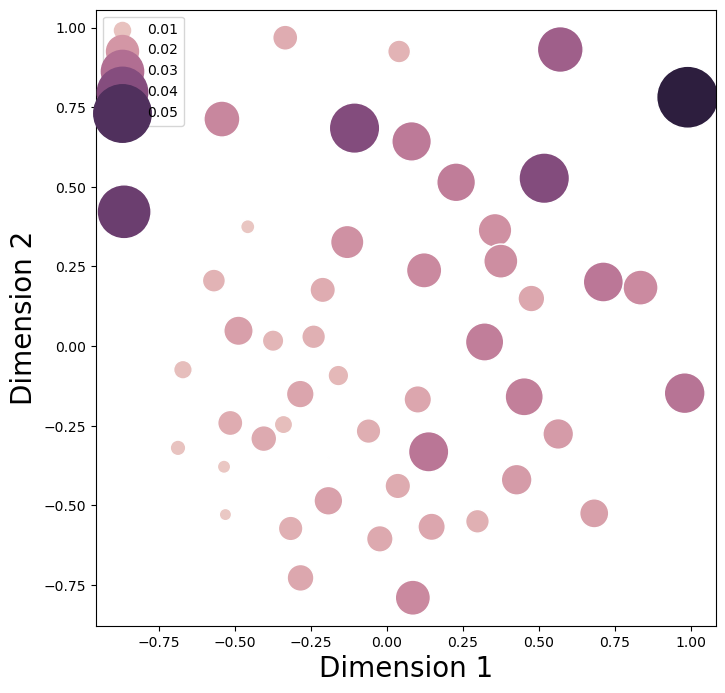

In [118]:
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x=beta_distances_transformed[:, 0], 
                y=beta_distances_transformed[:, 1],
                size=best_alpha.mean(axis=0),
                hue=best_alpha.mean(axis=0),
                sizes=(1, 2000))
ax.set_xlabel('Dimension 1', size=20)
ax.set_ylabel('Dimension 2', size=20)

## Describe clusters by high lift items

In [119]:
train_household_key = train_grocery_df.groupby('BASKET_ID').nth(0)['household_key']
best_gamma_df = pd.DataFrame(best_gamma, index=train_household_key)
best_gamma_df.head()

0             1             2             3   \
household_key                                                           
1172           4.225270e-15  3.381267e-12  9.626843e-10  2.905653e-11   
718            8.224485e-15  3.257303e-08  8.598047e-09  2.053887e-04   
1060           4.007686e-13  2.461360e-07  1.494906e-07  9.077537e-05   
1130           5.886680e-15  2.280415e-12  4.992587e-09  9.992659e-10   
212            5.068844e-16  1.545857e-09  1.077745e-09  9.530000e-05   

                         4             5             6             7   \
household_key                                                           
1172           2.395793e-23  5.153415e-19  5.454951e-16  3.505320e-22   
718            5.271702e-16  2.609488e-15  1.587328e-13  1.435173e-14   
1060           3.471372e-16  2.052827e-15  7.679658e-13  1.544994e-14   
1130           1.028919e-21  2.992780e-21  7.422451e-17  7.418160e-21   
212            2.926779e-18  3.173550e-17  2.344647e-15  6.799619e-16   

                         8             9   ...            40            41  \
household_key                              ...                               
1172           1.213191e-18  1.776841e-17  ...  5.352852e-19  1.860433e-08   
718            1.275820e-16  1.505438e-13  ...  6.066246e-05  9.526668e-05   
1060           1.101105e-15  1.276753e-12  ...  3.028302e-05  1.378897e-03   
1130           5.499883e-19  2.243233e-15  ...  8.031530e-15  1.772867e-07   
212            2.289535e-18  2.915025e-15  ...  9.895047e-10  6.686699e-06   

                         42            43            44            45  \
household_key                                                           
1172           3.775756e-10  9.034154e-18  4.115998e-14  3.421609e-18   
718            2.492863e-09  4.656619e-14  5.081565e-15  9.052480e-15   
1060           1.344348e-08  5.583298e-13  6.474088e-14  8.538284e-15   
1130           7.139046e-10  1.035035e-15  7.504500e-16  5.163825e-18   
212            2.694586e-11  1.689989e-15  7.011303e-17  2.837164e-16   

                         46        47            48            49  
household_key                                                      
1172           1.469235e-12  0.476845  5.498890e-05  1.018625e-10  
718            2.396000e-11  0.002419  1.389017e-05  1.363026e-10  
1060           1.642211e-09  0.032261  2.168609e-04  1.058174e-09  
1130           1.916865e-10  0.005127  1.802579e-04  3.987622e-11  
212            1.293887e-12  0.000200  2.561678e-07  3.871076e-13  

[5 rows x 50 columns]

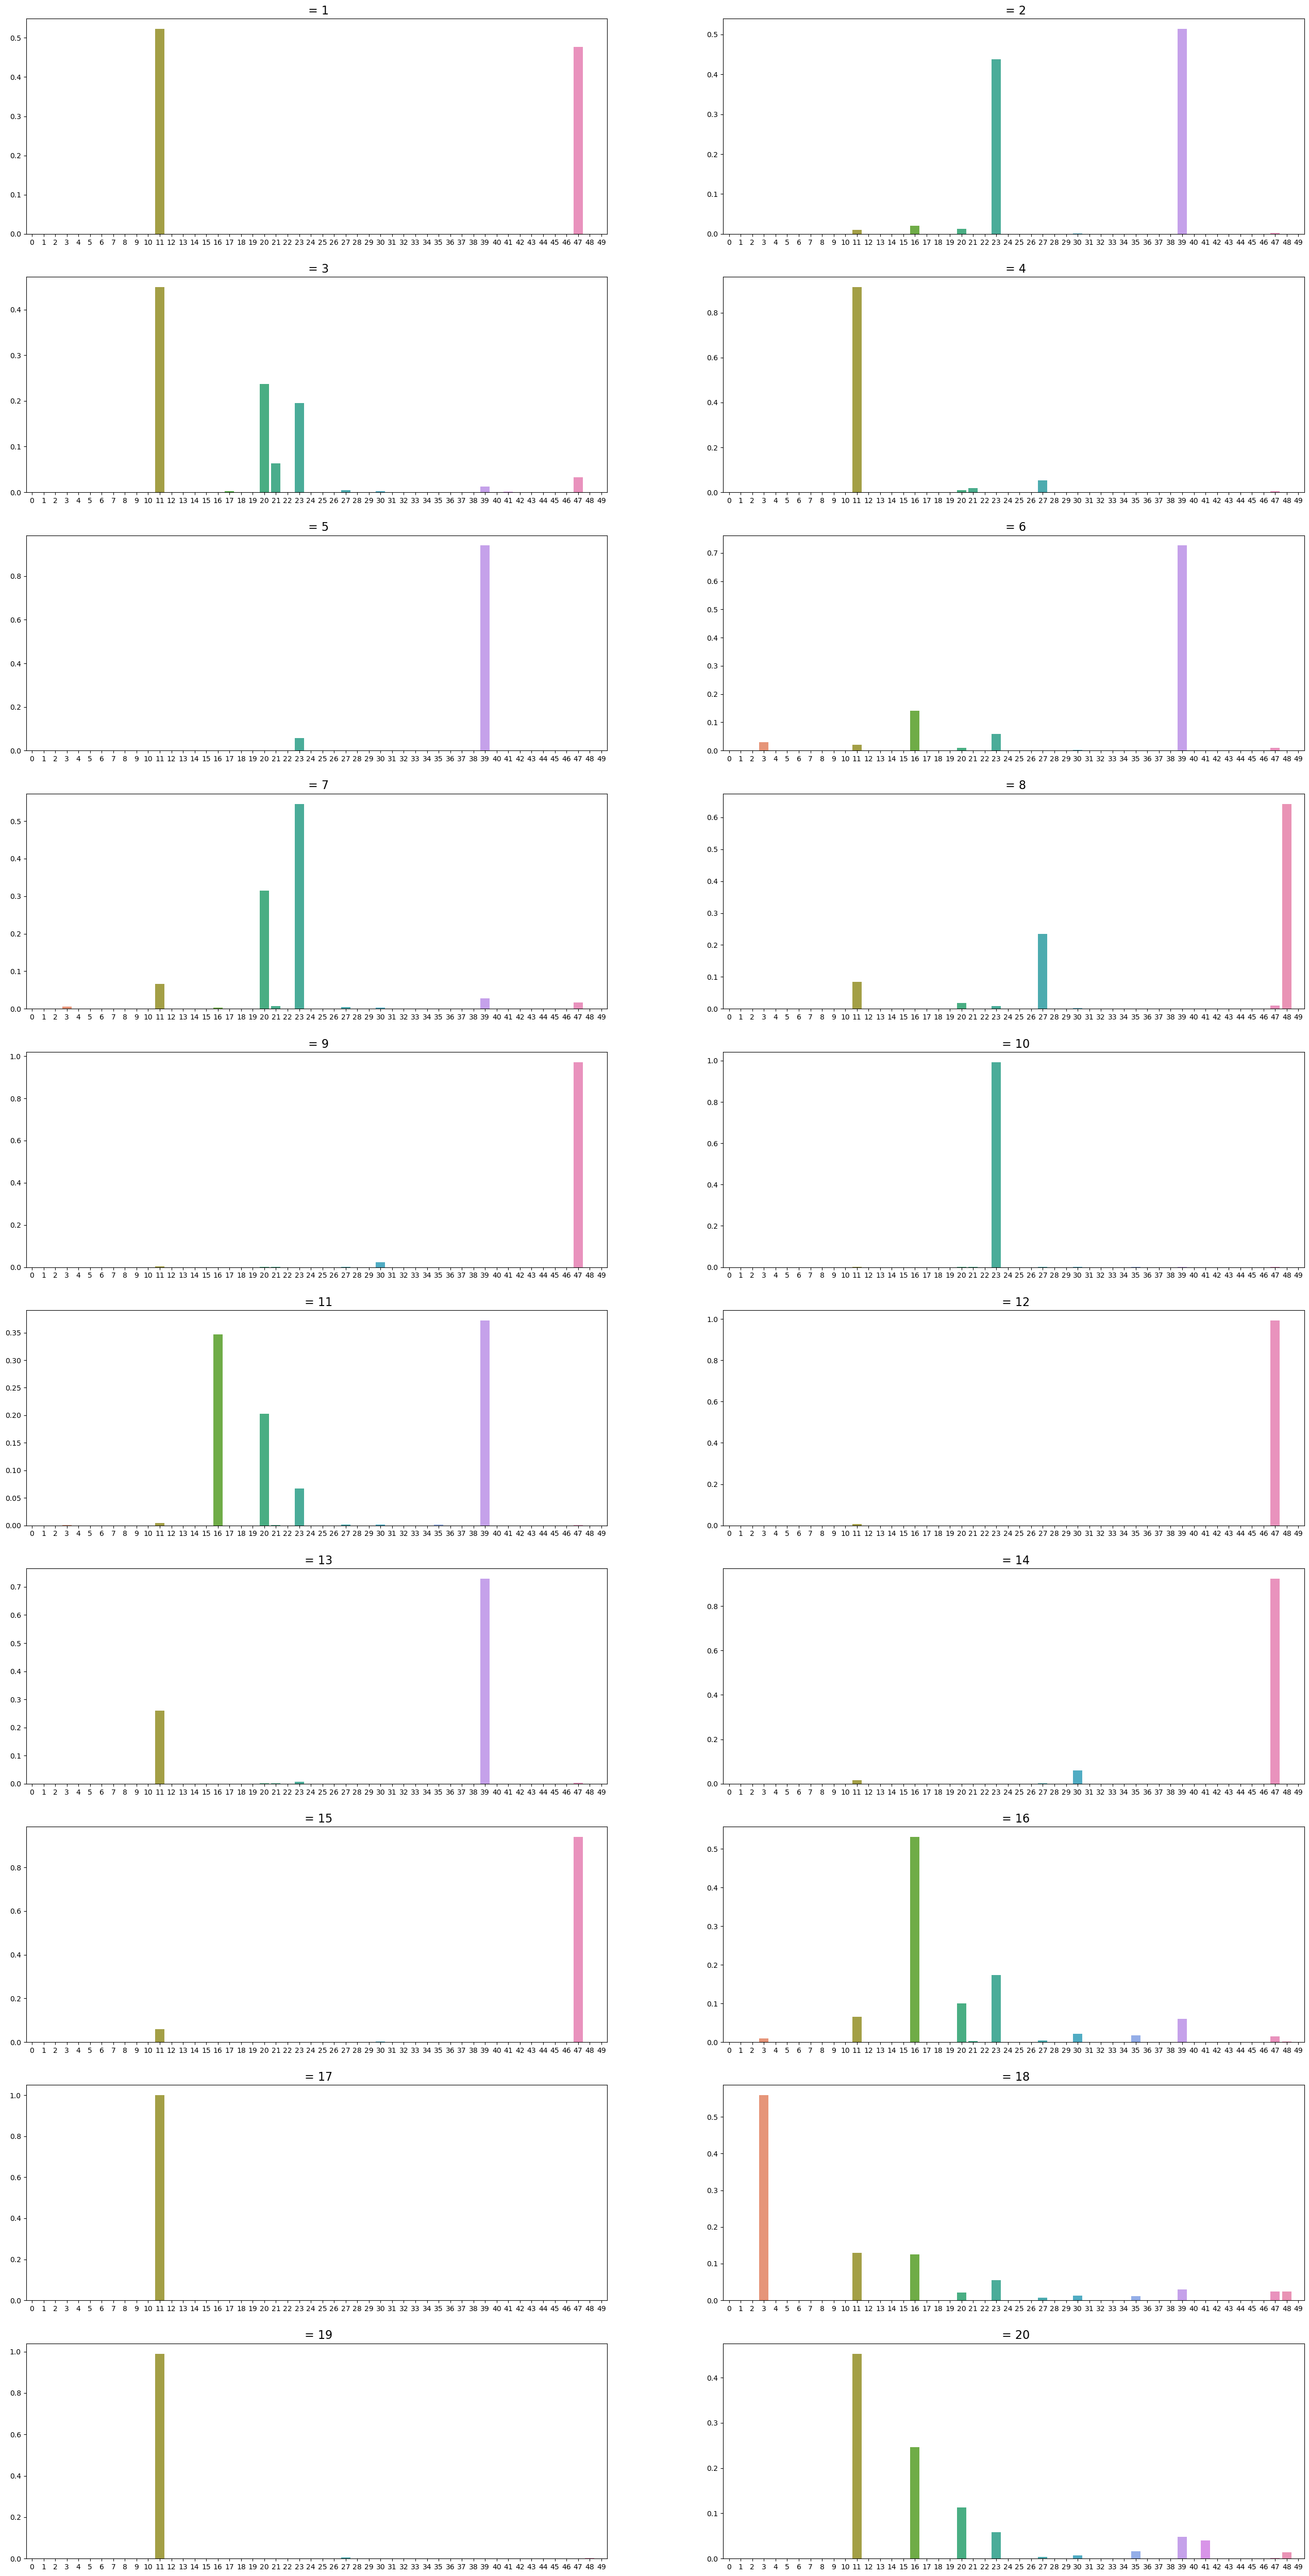

In [120]:
fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(32,64))
for i in range(20):
    sns.barplot(x=list(range(best_gamma.shape[1])), y=best_gamma[i], ax=axes[(i//2)][i%2])
    axes[(i//2)][i%2].set_title(' = %i' % (i+1), size=16)

In [121]:
cluster_weights_by_basket_id = {}
for i, (individual_id, basket_id) in enumerate(train_counts_df.index):
    cluster_weights_by_basket_id[basket_id] = best_gamma[i]

__Compute global product purchase probabilities__

In [122]:
product_counts = train_grocery_df.groupby('PRODUCT_ID')['PRODUCT_ID'].value_counts()
##product_counts.index = product_counts.index.droplevel()
product_purchase_prob = product_counts / len(train_grocery_df)

<Axes: xlabel='count', ylabel='Density'>

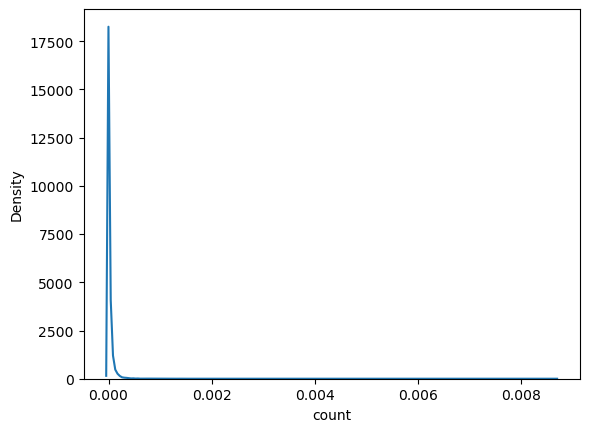

In [123]:
sns.kdeplot(product_purchase_prob)

In [124]:
high_freq_items_prob = product_purchase_prob[product_purchase_prob > 0.0001]
high_freq_items_prob_df = pd.DataFrame(data={'Total purchase prob': high_freq_items_prob})
high_freq_items_prob_df

Total purchase prob
PRODUCT_ID                     
819063                 0.000188
819304                 0.000174
819330                 0.000126
819518                 0.000138
819765                 0.000346
...                         ...
15506577               0.000145
15511891               0.000129
15596279               0.000146
15596488               0.000113
15596515               0.000105

[2119 rows x 1 columns]

In [125]:
total_cluster_weights = best_gamma.sum(axis=0)

products_filepath = r"C:\Users\Tinga\Documents\CS 4103 Intelligent Systems\MINI-RESEARCH CS4103\MNMM-main\data\product.csv"
products_df = pd.read_csv(products_filepath)
products_df.set_index('PRODUCT_ID', inplace=True)


def product_prob_for_component(g, k):
    total_product_cluster_weight = 0
    for basket_id in g['BASKET_ID']:
        total_product_cluster_weight += cluster_weights_by_basket_id[basket_id][k]
    return total_product_cluster_weight / total_cluster_weights[k]

def get_high_lift_frequent_items(k):

    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift.join(products_df, how='inner')

def get_high_lift_frequent_item(k):

    product_cluster_purchase_prob = train_grocery_df.groupby('PRODUCT_ID').apply(lambda g: product_prob_for_component(g, k))
    lift = product_cluster_purchase_prob / product_purchase_prob
    lift_df = pd.DataFrame(data={'Lift': lift})
    high_lift_df = lift_df[lift_df.Lift > 10]
    high_freq_and_high_lift = high_freq_items_prob_df.join(high_lift_df, how='inner').sort_values('Lift', ascending=False)
    return high_freq_and_high_lift

In [126]:
cluster_1_high_lift_items_df = get_high_lift_frequent_items(k=0)

In [127]:
cluster_1_high_lift_items_df

Total purchase prob        Lift  MANUFACTURER DEPARTMENT  \
PRODUCT_ID                                                             
1019883                0.000107  147.679431          1807    GROCERY   
1065061                0.000110  130.795761           151    GROCERY   
1083328                0.000133  126.204857          5569    GROCERY   
1048893                0.000130  122.087230          5569    GROCERY   
996009                 0.000123  121.818557           320    GROCERY   
...                         ...         ...           ...        ...   
870547                 0.000776   10.029776           516    GROCERY   
1120443                0.000270   10.010444           794    GROCERY   
995242                 0.007776   10.005213            69    GROCERY   
1056509                0.001086   10.005065            69    GROCERY   
13190294               0.000105   10.004673            69    GROCERY   

               BRAND          COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                                     
1019883     National  FRZN MEAT/MEAT DINNERS  FRZN SS PREMIUM ENTREES/DNRS/N   
1065061     National  FRZN MEAT/MEAT DINNERS  FRZN SS PREMIUM ENTREES/DNRS/T   
1083328     National  FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
1048893     National  FRZN MEAT/MEAT DINNERS  SS ECONOMY ENTREES/DINNERS ALL   
996009      National  FRZN MEAT/MEAT DINNERS  FRZN SS PREMIUM ENTREES/DNRS/T   
...              ...                     ...                             ...   
870547      National              MARGARINES       MARGARINE: TUBS AND BOWLS   
1120443     National    FRZN BREAKFAST FOODS   WAFFLES/PANCAKES/FRENCH TOAST   
995242       Private     FLUID MILK PRODUCTS           FLUID MILK WHITE ONLY   
1056509      Private        MILK BY-PRODUCTS                  COTTAGE CHEESE   
13190294     Private              BAG SNACKS                    POTATO CHIPS   

           CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                       
1019883                    8 OZ  
1065061                 10.5 OZ  
1083328                    8 OZ  
1048893                  8.5 OZ  
996009                    14 OZ  
...                         ...  
870547                    45 OZ  
1120443                 12.3 OZ  
995242                           
1056509                   24 OZ  
13190294                11.5 OZ  

[895 rows x 8 columns]

In [128]:
cluster_2_high_lift_items_df = get_high_lift_frequent_items(k=1)

In [129]:
cluster_2_high_lift_items_df

Total purchase prob        Lift  MANUFACTURER DEPARTMENT  \
PRODUCT_ID                                                             
1123434                0.000180  134.936869           236    GROCERY   
953320                 0.000179  125.078880            69    GROCERY   
866573                 0.000119  123.825543            69    GROCERY   
1004909                0.000107  116.144019            69    GROCERY   
924804                 0.000193  113.025595           794    GROCERY   
...                         ...         ...           ...        ...   
873203                 0.000371   10.063097            69    GROCERY   
1038217                0.001310   10.058377            69    GROCERY   
8090537                0.001407   10.056151           103    GROCERY   
1036501                0.000364   10.039425           103    GROCERY   
7167249                0.000197   10.022822           544    GROCERY   

               BRAND        COMMODITY_DESC              SUB_COMMODITY_DESC  \
PRODUCT_ID                                                                   
1123434     National  FRZN BREAKFAST FOODS           FRZN BREAKFAST PASTRY   
953320       Private  FRZN BREAKFAST FOODS   WAFFLES/PANCAKES/FRENCH TOAST   
866573       Private  FRZN BREAKFAST FOODS   WAFFLES/PANCAKES/FRENCH TOAST   
1004909      Private  FRZN BREAKFAST FOODS   WAFFLES/PANCAKES/FRENCH TOAST   
924804      National  FRZN BREAKFAST FOODS   WAFFLES/PANCAKES/FRENCH TOAST   
...              ...                   ...                             ...   
873203       Private                CHEESE                 SHREDDED CHEESE   
1038217      Private  CRACKERS/MISC BKD FD  SOUP CRACKERS (SALTINE/OYSTER)   
8090537     National           SOFT DRINKS  SOFT DRINKS 12/18&15PK CAN CAR   
1036501     National           SOFT DRINKS  SFT DRNK 2 LITER BTL CARB INCL   
7167249     National            BAG SNACKS  SGL SV/VEND MACH SNACKS CHIP/P   

           CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                       
1123434                 11.5 OZ  
953320                  12.3 OZ  
866573                  12.3 OZ  
1004909                 12.3 OZ  
924804                  12.3 OZ  
...                         ...  
873203                     8 OZ  
1038217                   16 OZ  
8090537                   12 OZ  
1036501                   2 LTR  
7167249                    1 OZ  

[748 rows x 8 columns]

In [130]:
cluster_3_high_lift_items_df = get_high_lift_frequent_items(k=2)

In [131]:
cluster_3_high_lift_items_df

Total purchase prob       Lift  MANUFACTURER DEPARTMENT     BRAND  \
PRODUCT_ID                                                                      
887342                 0.000123  89.601617          1251    GROCERY  National   
831815                 0.000176  81.218063          1002    GROCERY  National   
1094107                0.000103  73.854111          1251    GROCERY  National   
924423                 0.000127  66.850029          1251    GROCERY  National   
9296965                0.000108  66.749379            69    GROCERY   Private   
...                         ...        ...           ...        ...       ...   
1138772                0.000125  10.094461           794    GROCERY  National   
959179                 0.000105  10.053181           194    GROCERY  National   
839243                 0.000171  10.047011           942    GROCERY  National   
6039859                0.000120  10.035889            69    GROCERY   Private   
940766                 0.000492  10.012938           317    GROCERY  National   

                            COMMODITY_DESC             SUB_COMMODITY_DESC  \
PRODUCT_ID                                                                  
887342                                SOUP  RTS SOUP: CHUNKY/HOMESTYLE ET   
831815                                SOUP       RAMEN NOODLES/RAMEN CUPS   
1094107                               SOUP                 CONDENSED SOUP   
924423                                SOUP                 CONDENSED SOUP   
9296965                               SOUP  RTS SOUP: CHUNKY/HOMESTYLE ET   
...                                    ...                            ...   
1138772     CONVENIENT BRKFST/WHLSM SNACKS               TOASTER PASTRIES   
959179                         COLD CEREAL              ALL FAMILY CEREAL   
839243           VEGETABLES - SHELF STABLE       MISCELLANEOUS VEGETABLES   
6039859                 PNT BTR/JELLY/JAMS                  PEANUT BUTTER   
940766                              CHEESE                SHREDDED CHEESE   

           CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                       
887342                  18.8 OZ  
831815                     3 OZ  
1094107                 10.5 OZ  
924423                 10.75 OZ  
9296965                 18.8 OZ  
...                         ...  
1138772                 14.7 OZ  
959179                     9 OZ  
839243                     6 OZ  
6039859                   64 OZ  
940766                     8 OZ  

[464 rows x 8 columns]

In [132]:
cluster_4_high_lift_items_df = get_high_lift_frequent_items(k=3)

In [133]:
cluster_4_high_lift_items_df

Total purchase prob        Lift  MANUFACTURER DEPARTMENT  \
PRODUCT_ID                                                             
1043663                0.000109  113.004036           531    GROCERY   
983659                 0.000100  107.422693           531    GROCERY   
1044188                0.000231   70.863450           317    GROCERY   
1104349                0.000200   54.107807           194    GROCERY   
1026346                0.000292   47.212372            69    GROCERY   
...                         ...         ...           ...        ...   
1076580                0.000126   10.166099          1194    GROCERY   
5565925                0.000184   10.094461           436    GROCERY   
830795                 0.000123   10.058358           236    GROCERY   
885290                 0.000729   10.039107           910    GROCERY   
1005172                0.000106   10.020319          1225    GROCERY   

               BRAND            COMMODITY_DESC  \
PRODUCT_ID                                       
1043663     National             CANNED JUICES   
983659      National             CANNED JUICES   
1044188     National                    CHEESE   
1104349     National               COLD CEREAL   
1026346      Private    REFRGRATD JUICES/DRNKS   
...              ...                       ...   
1076580     National    REFRGRATD JUICES/DRNKS   
5565925     National    REFRGRATD JUICES/DRNKS   
830795      National  REFRGRATD DOUGH PRODUCTS   
885290      National    BAKED BREAD/BUNS/ROLLS   
1005172     National       FLUID MILK PRODUCTS   

                        SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
PRODUCT_ID                                                       
1043663      APPLE JUICE & CIDER (OVER 50%                46 OZ  
983659      BLENDED JUICE&COMBINATIONS (OV                46 OZ  
1044188              NON-IWS SINGLE CHEESE                16 OZ  
1104349                       ADULT CEREAL              15.6 OZ  
1026346     DAIRY CASE FRUIT DRINKS (NO JU                 1 GA  
...                                    ...                  ...  
1076580     DAIRY CASE 100% PURE JUICE - O                64 OZ  
5565925     DAIRY CASE 100% PURE JUICE - O                64 OZ  
830795       REFRIGERATED BISCUITS REGULAR                12 OZ  
885290      MAINSTREAM WHEAT/MULTIGRAIN BR                20 OZ  
1005172       REFRIGERATED COFFEE CREAMERS                16 OZ  

[199 rows x 8 columns]

__predictive profiles__

In [134]:
test_counts_df.index = test_counts_df.index.droplevel()

In [135]:
from scipy.special import logsumexp
from scipy.stats import multinomial

best_gamma_df = pd.DataFrame(best_gamma, index=train_household_ids)
best_alpha_df = pd.DataFrame(best_alpha, index=train_household_ids)


def compute_predictive_profile_from_sampling(household_key, complete):
    household_assignments = best_gamma_df[best_gamma_df.index == household_key]
    if len(household_assignments) == 0:
        return 0
    # All assignments are equal, as per the modelization, so we just take the first one
    
    alpha = best_alpha_df[best_alpha_df.index == household_key].iloc[0]
    
    K, C = best_beta.shape
    n=100
    total = np.zeros((C))
    for i, assignment in household_assignments.iterrows():
        for k in range(K):
            k_samples = alpha[k] * multinomial.rvs(n=100, p=best_beta[k], size=n)
            if complete:
                k_samples *= assignment[k]
            total += k_samples.sum(axis=0)
    probs = total / total.sum()
    return probs

    
def compute_household_test_purchase(household_key):
    test_basket_ids=test_grocery_df.loc[test_grocery_df['household_key'] == household_key, 'BASKET_ID'].unique()
    household_test_counts_df = test_counts_df[test_counts_df.index.isin(test_basket_ids)].sum(axis=0)
    return household_test_counts_df / household_test_counts_df.sum()
    
def plot_prediction_vs_reality(household_key, complete=False):
    fig, axes = plt.subplots(nrows=2, figsize=(32,14))
    axes = axes.ravel()
    
    predictive_probs = compute_predictive_profile_from_sampling(household_key, complete)
    sns.barplot(x=np.arange(predictive_probs.size), y=predictive_probs, ax=axes[0])
    axes[0].set_title('Purchases probabilities prediction for household %s' % str(household_key), size=20)
    axes[0].set_xlabel('Categories', size=20)
    axes[0].set_ylabel('Probability', size=20)
    
    test_probs = compute_household_test_purchase(household_key)
    sns.barplot(x=np.arange(test_probs.size), y=test_probs, ax=axes[1])
    axes[1].set_title('Purchases from the test set for household %s' % str(household_key), size=20)
    axes[1].set_xlabel('Categories', size=20)
    axes[1].set_ylabel('Probability', size=20)

    l1_distance = np.abs(predictive_probs - test_probs).sum()
    plt.text(0.5, -0.25, 'L1 distance between prediction and test data: %.3f' % l1_distance,
             horizontalalignment='center', verticalalignment='center', transform = axes[1].transAxes, size=30)

In [136]:
best_alpha_df.index

Index([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
       ...
       2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500],
      dtype='int64', name='household_key', length=172328)

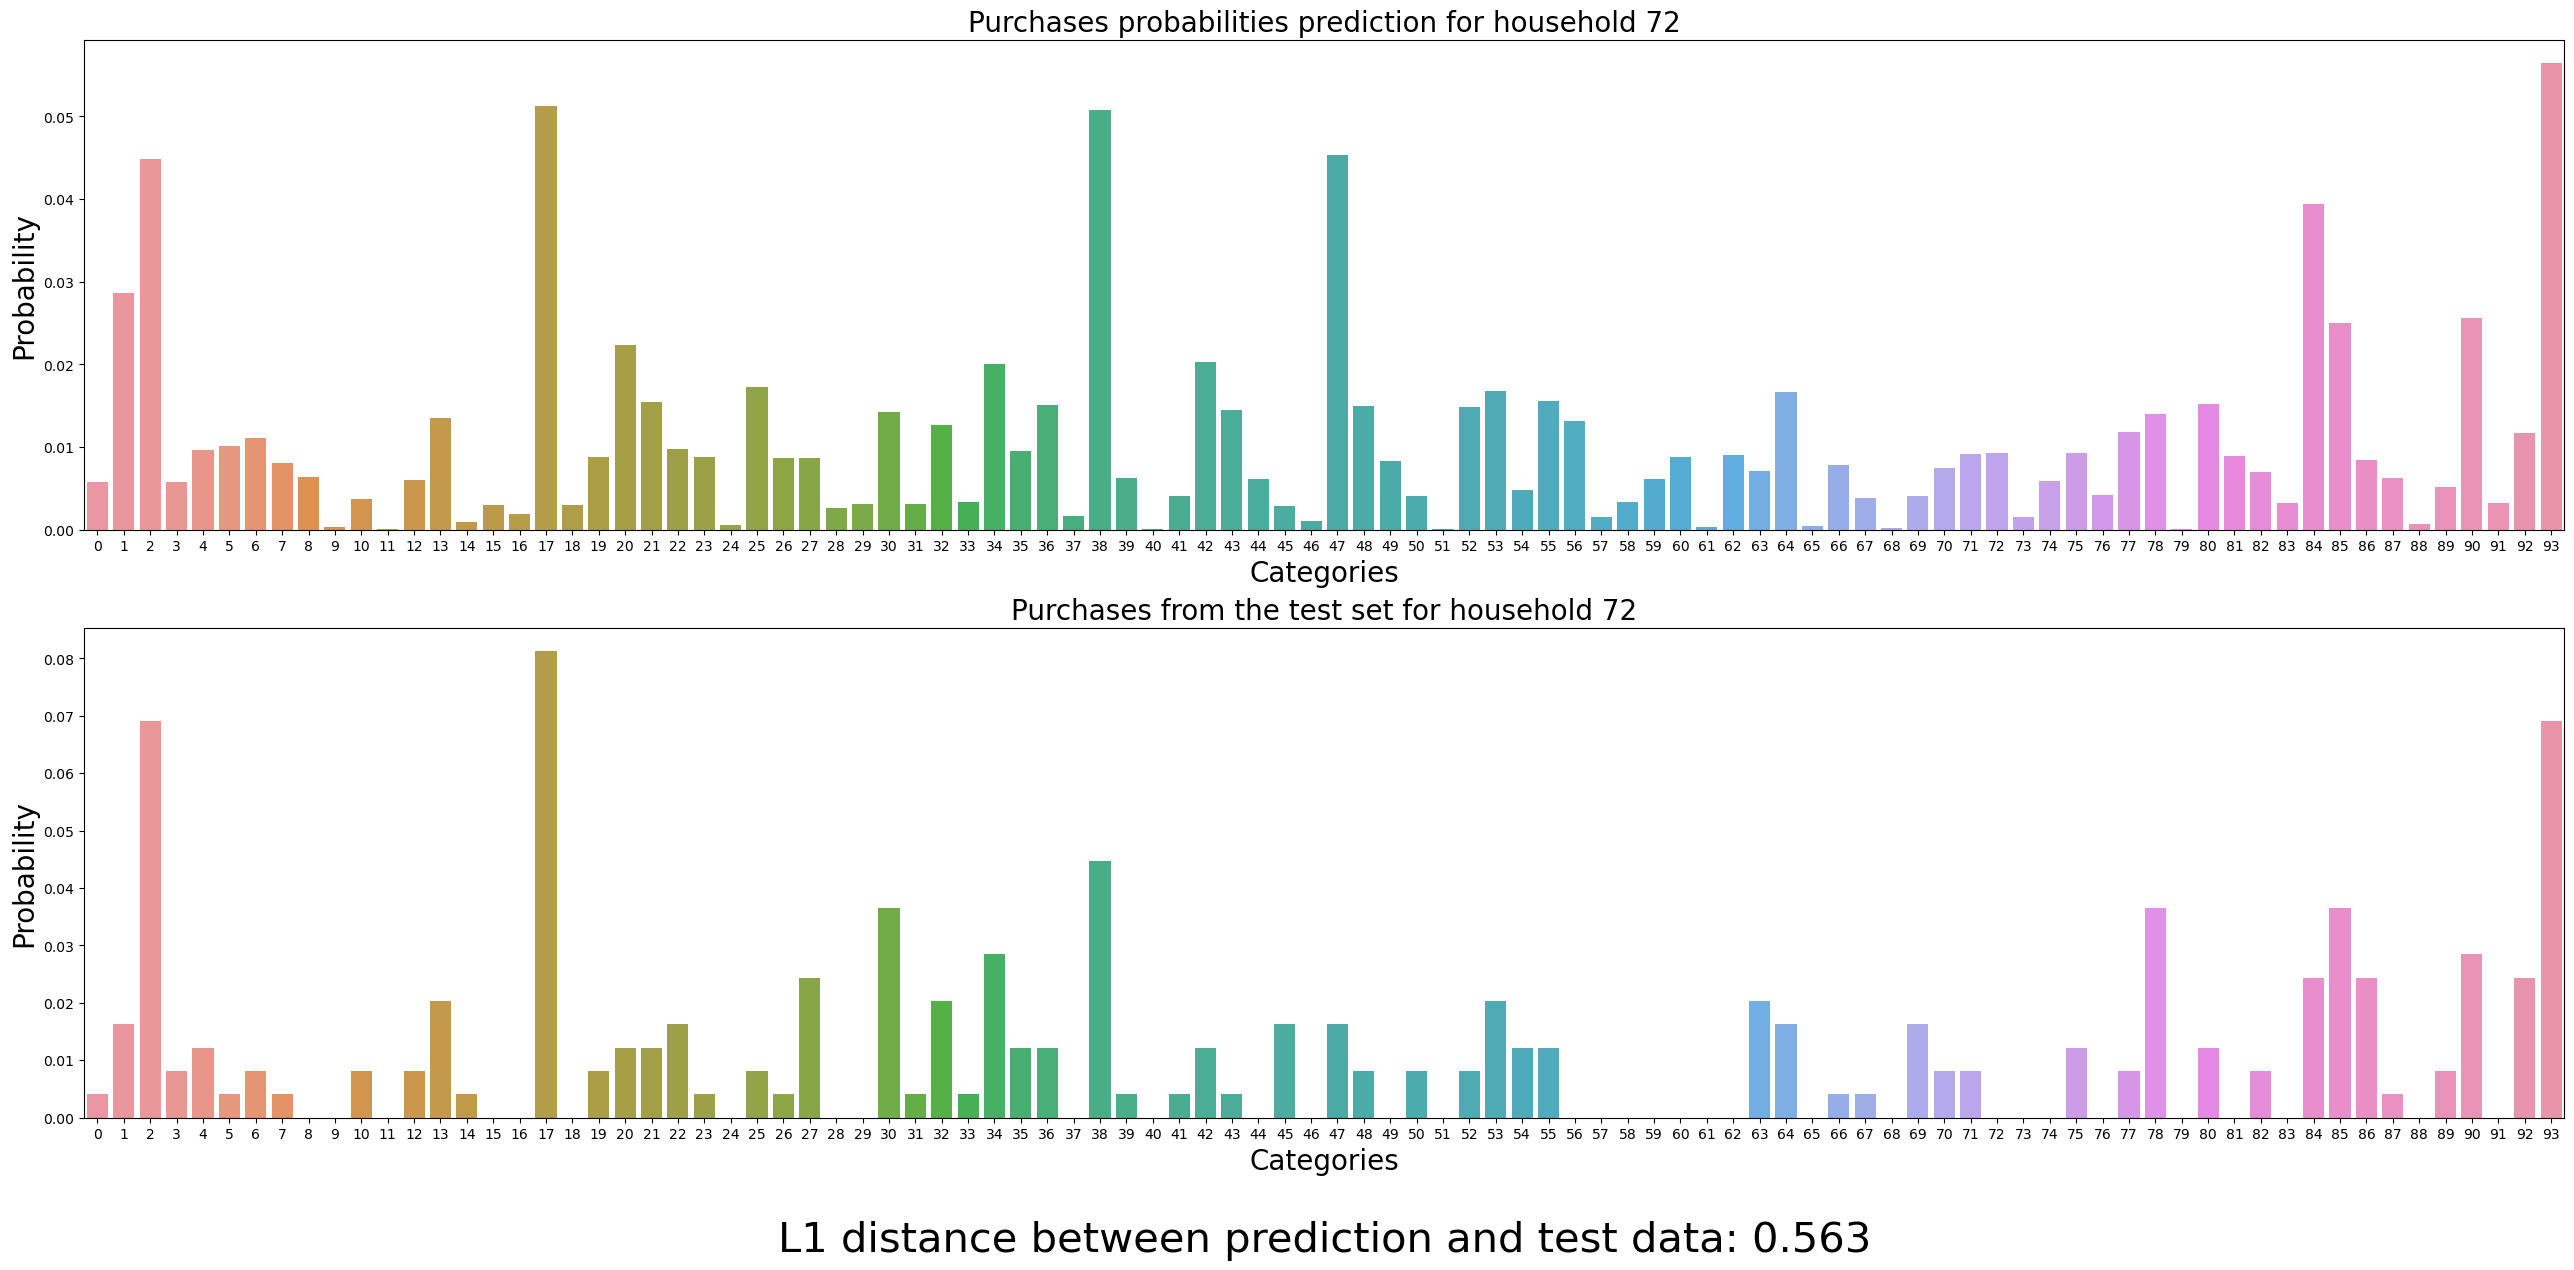

In [137]:
plot_prediction_vs_reality(72, complete=True)

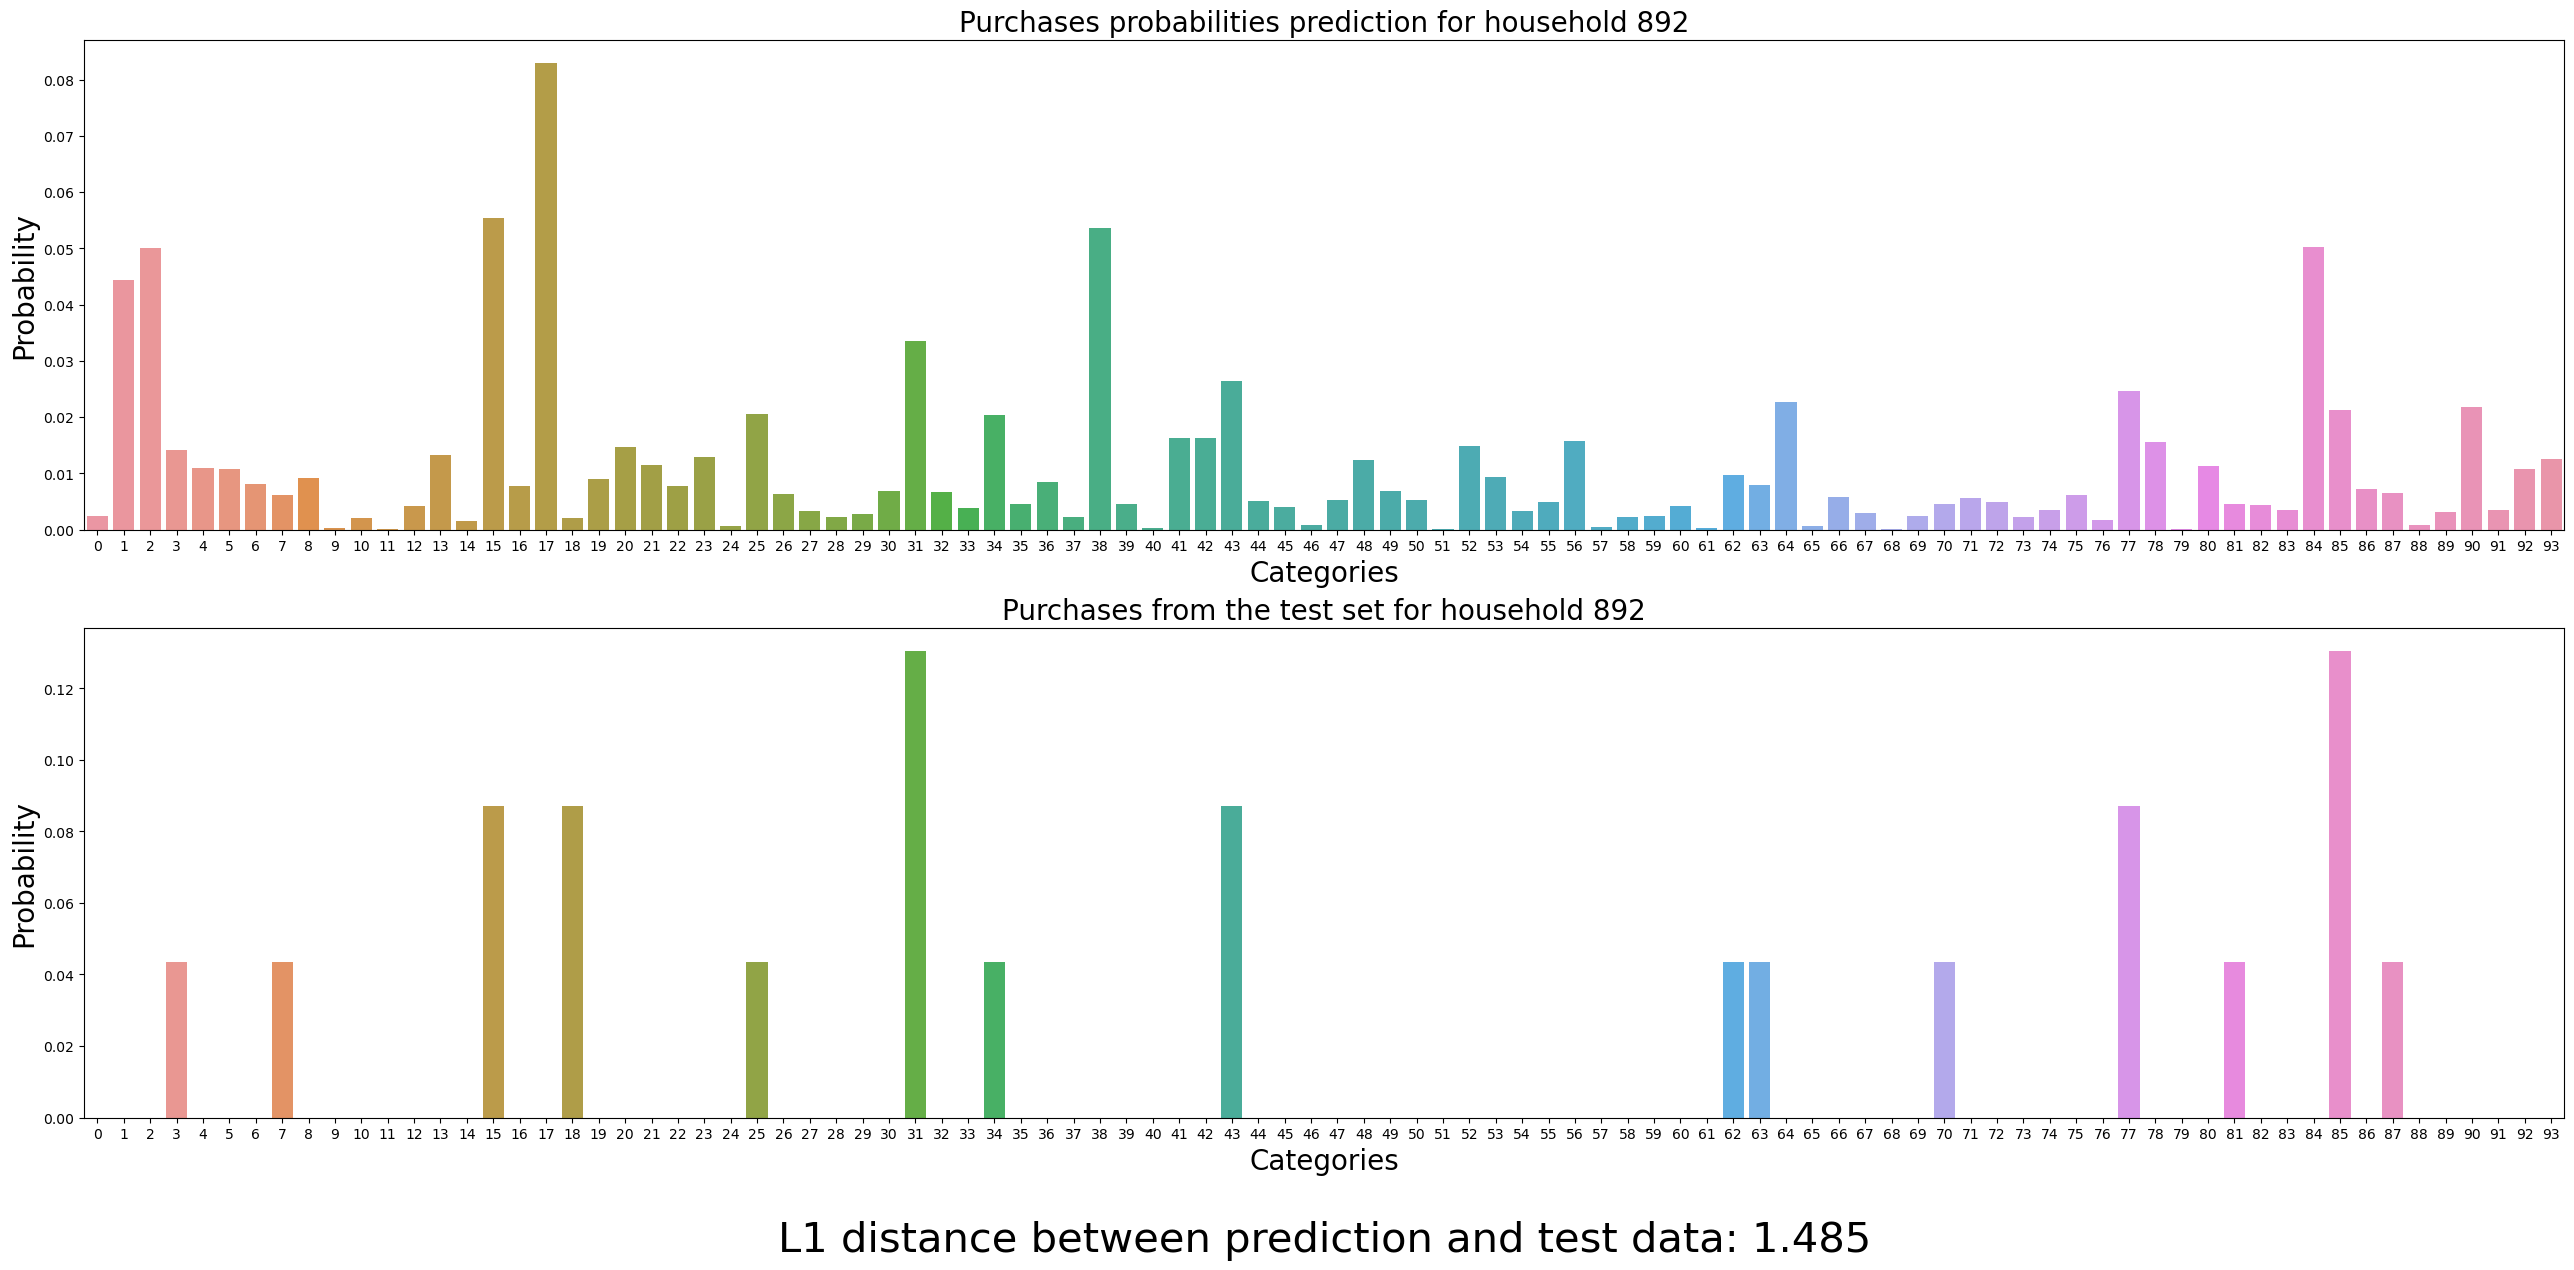

In [138]:
plot_prediction_vs_reality(892, complete=True)

In [139]:
from tqdm import tqdm

unique_test_household_ids = test_grocery_df['household_key'].unique()
predictions_distances = {}
for household_id in tqdm(unique_test_household_ids):
    predictive_probs = compute_predictive_profile_from_sampling(household_id, True)
    test_probs = compute_household_test_purchase(household_id)
    l1_distance = np.abs(predictive_probs - test_probs).sum()
    predictions_distances[household_id] = l1_distance

100%|██████████| 2361/2361 [1:03:18<00:00,  1.61s/it]


In [140]:
global_predictions_distances = pickle.load(open('predictions_distances.p', 'rb'))

C:\Users\Tinga\AppData\Local\Temp\ipykernel_27240\444051981.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = predictions_distances[household_id] / global_dist


Text(0, 0.5, 'Error with individuals model')

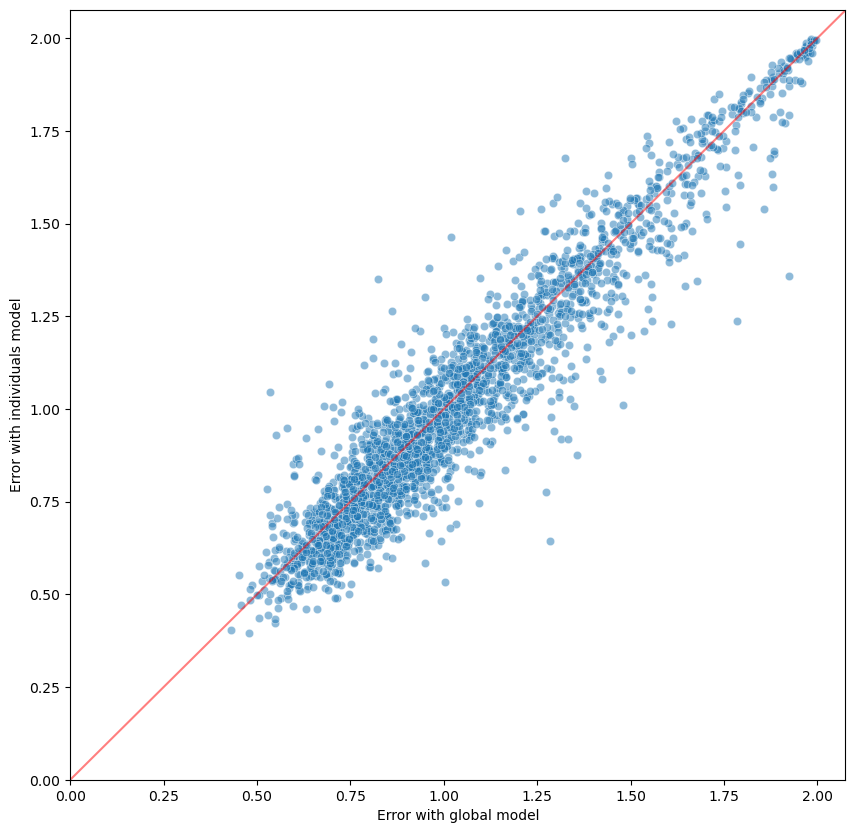

In [141]:
import matplotlib.lines as lines

distances = np.zeros((len(global_predictions_distances), len(global_predictions_distances)))

best_prediction_household_id = None
prev_ratio = float('inf')
for i, (household_id, global_dist) in enumerate(global_predictions_distances.items()):
    distances[i, 0] = global_dist
    distances[i, 1] = predictions_distances[household_id]
    ratio = predictions_distances[household_id] / global_dist
    if ratio < prev_ratio:
        prev_ratio = ratio
        best_prediction_household_id = household_id
distances = distances[distances[:, 0] > 0]

plt.figure(figsize=(10,10))
ax = sns.scatterplot(x=distances[:, 0], y=distances[:, 1], alpha=0.5)
ax.set_ybound(0)
ax.set_xbound(0)
l = lines.Line2D([0, 2.1], [0, 2.1], linestyle='-', color='red', alpha=0.5)
ax.add_line(l)
ax.set_xlabel('Error with global model')
ax.set_ylabel('Error with individuals model')

In [142]:
# Pct of predictions with a higher error with the global model than the individual model
(((distances[:, 0] - distances[:, 1]) > 0).sum() / distances.shape[0]) * 100

58.524173027989825